# Application of linear response theory method to observational data from IAP
Here, we apply the linear response theory method to observational data from IAP. This is done using the block bootstrapping methodology. We also check that the observational data meets the significant criteria found in individual_ensemble_members_CESM.ipynb which is a sufficient condition for application of the methodology.

In [1]:
import scipy.io
import netCDF4
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import os, glob 
import imageio
from matplotlib import animation
import copy
import cartopy as cart
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter #see https://scitools.org.uk/cartopy/docs/v0.15/examples/tick_labels.html
import certifi
import ssl
import math
ssl._create_default_https_context = ssl._create_unverified_context
from scipy import stats
from xgcm import Grid
import statsmodels.api as sm
import matplotlib.ticker as ticker
from matplotlib.axes._secondary_axes import SecondaryAxis
import xesmf as xe
import warnings
import os

Load in observational temperature and salinity data from the Cheng et al. 2020 paper. The data can be downloaded from http://www.ocean.iap.ac.cn/pages/dataService/dataService.html

In [2]:
#Load in temperature data and then take annual mean
mean_annual_temp=np.empty([50,180,360])
for j in np.linspace(1972,2021,50):
    j=int(j)
    surface_temp=np.empty([12,180,360])
    surface_temp[:]=np.nan
    for i in np.linspace(1,12,12):
        i=int(i)
        if i<10:
            f='/scratch/abf376/IAP_temp_data_all/CZ16_1_2000m_Temp_year_'
            f+=str(j)
            f+='_month_0'
        else:
            f='/scratch/abf376/IAP_temp_data_all/CZ16_1_2000m_Temp_year_'
            f+=str(j)
            f+='_month_'
        f+=str(i)
        f+='.nc'
        lat = xr.open_dataset(f)['lat']
        lon = xr.open_dataset(f)['lon']
        depth_std = xr.open_dataset(f)['depth_std']
        temp=xr.open_dataset(f)['temp']
        temp=temp.where(temp<999)
        surface_temp[i-1,:,:]=temp[:,:,0]
    surface_temp=xr.DataArray(surface_temp,dims=["month","lat","lon"],coords=[np.linspace(1,12,12),lat,lon])
    surface_temp=surface_temp.mean('month')
    mean_annual_temp[j-1973,:,:]=surface_temp
mean_annual_temp=xr.DataArray(mean_annual_temp,dims=["year","lat","lon"],coords=[np.linspace(1972,2021,50),lat,lon])

In [3]:
#Load in salinity data and take annual mean
mean_annual_sal=np.empty([50,180,360])
for j in np.linspace(1972,2021,50):
    j=int(j)
    surface_sal=np.empty([12,180,360])
    surface_sal[:]=np.nan
    for i in np.linspace(1,12,12):
        i=int(i)
        if i<10:
            f='/scratch/abf376/IAP_salinity_data/CZ16_1_2000m_salinity_year_'
            f+=str(j)
            f+='_month_0'
        else:
            f='/scratch/abf376/IAP_salinity_data/CZ16_1_2000m_salinity_year_'
            f+=str(j)
            f+='_month_'
        f+=str(i)
        f+='.nc'
        lat = xr.open_dataset(f)['lat']
        lon = xr.open_dataset(f)['lon']
        depth_std = xr.open_dataset(f)['depth_std']
        sal=xr.open_dataset(f)['salinity']
        sal=sal.where(sal<999)
        surface_sal[i-1,:,:]=sal[:,:,0]
    surface_sal=xr.DataArray(surface_sal,dims=["month","lat","lon"],coords=[np.linspace(1,12,12),lat,lon])
    surface_sal=surface_sal.mean('month')
    mean_annual_sal[j-1973,:,:]=surface_sal 
mean_annual_sal=xr.DataArray(mean_annual_sal,dims=["year","lat","lon"],coords=[np.linspace(1972,2021,50),lat,lon])

Regrid the data

In [4]:
ds_out = xe.util.grid_global(1, 1)
regridder = xe.Regridder(mean_annual_sal, ds_out, "bilinear",periodic=True)
regrid_iap = regridder(mean_annual_sal)
regrid_iap=regrid_iap.rename({'y': 'latitude','x': 'longitude','year':'time'})
regrid_iap=regrid_iap.assign_coords(latitude=regrid_iap.lat[:,0],longitude=regrid_iap.lon[0,:])

regrid_iap_temp=regridder(mean_annual_temp)
regrid_iap_temp=regrid_iap_temp.rename({'y': 'latitude','x': 'longitude','year':'time'})
regrid_iap_temp=regrid_iap_temp.assign_coords(latitude=regrid_iap_temp.lat[:,0],longitude=regrid_iap_temp.lon[0,:])

/ext3/miniconda3/lib/python3.9/site-packages/xarray/core/dataarray.py:780: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data


In [5]:
#Create area grid

import sys
sys.path.append('/scratch/abf376/freshwater_flux_linresp/tools')

from area_grid import *

area=area_grid(latitudes=np.array(regrid_iap.latitude),longitudes=regrid_iap.longitude)
area=xr.DataArray(area,dims=["latitude","longitude"],coords=[regrid_iap.latitude,regrid_iap.longitude])

In [6]:
def area_weighted_disjoint(area,i,salt_surface,thing_to_weight,x,a2):
    return ((thing_to_weight*area).where(salt_surface>(x[a2[i]])).where(salt_surface<(x[a2[i+1]]))).sum()/((area).where(salt_surface>(x[a2[i]])).where(salt_surface<(x[a2[i+1]]))).sum()

Perform clustering on the observational data. Note, one of the sensitivities that we can look at is the number of clusters. Feel free to rerun this notebook with different n values. We find it has very little effect on the final results. E.g. response as a proportion of FAFMIP flux: 


Method with 5 clusters: 0.3102953235218418 ± 0.07693984091229823

Method with 6 clusters: 0.2999548084768831 ± 0.08030572662010688

Method with 7 clusters: x ± x


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
1.0
(100000, 7)


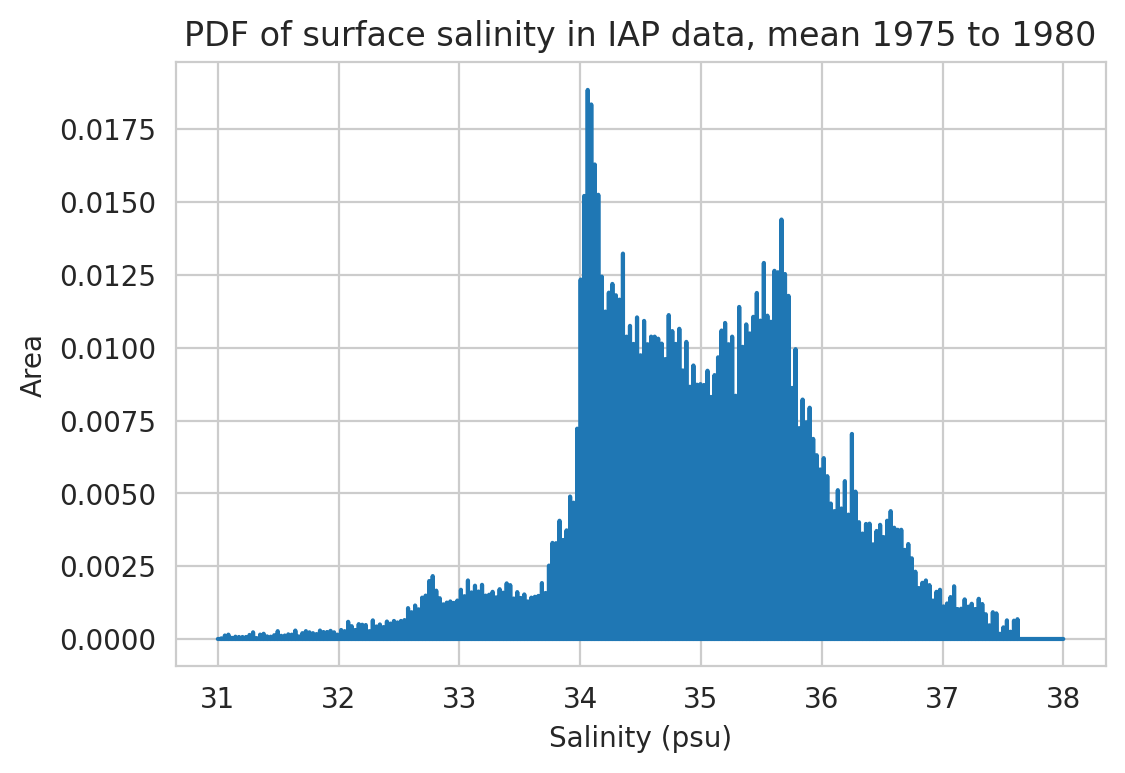

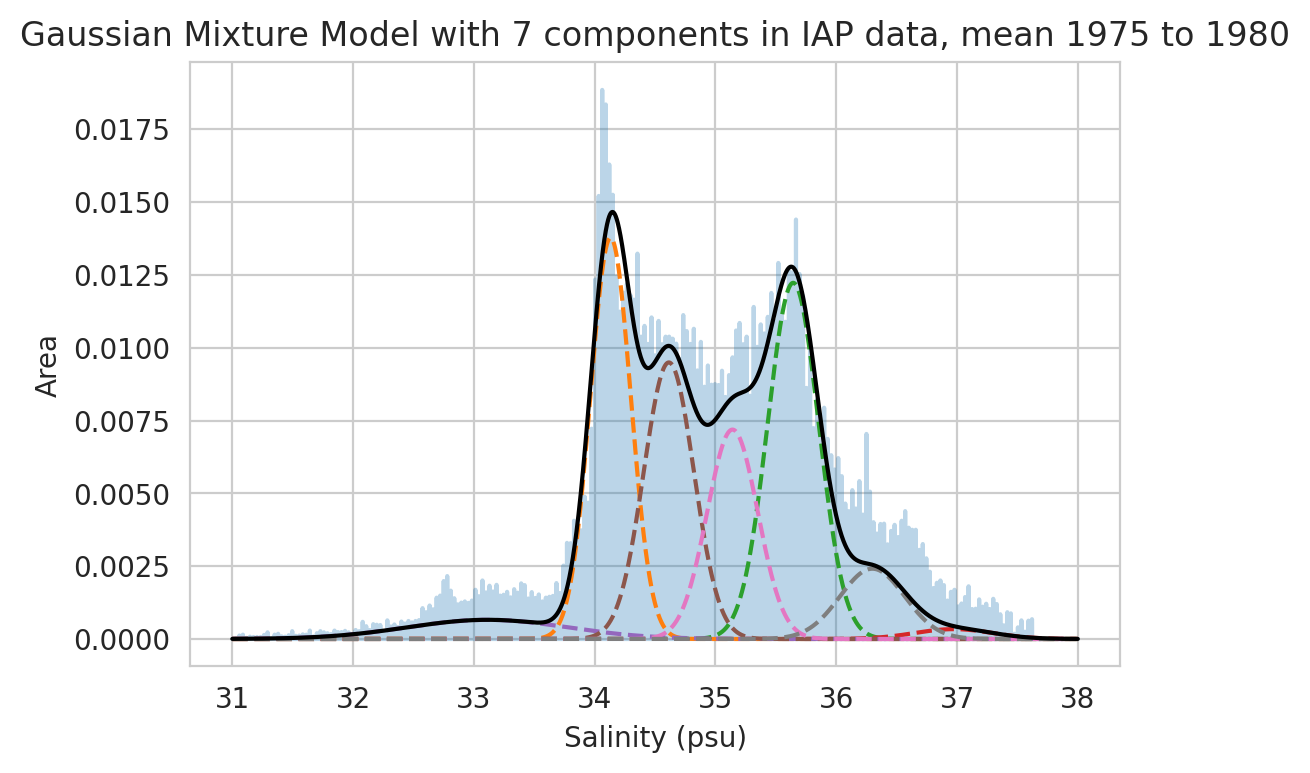

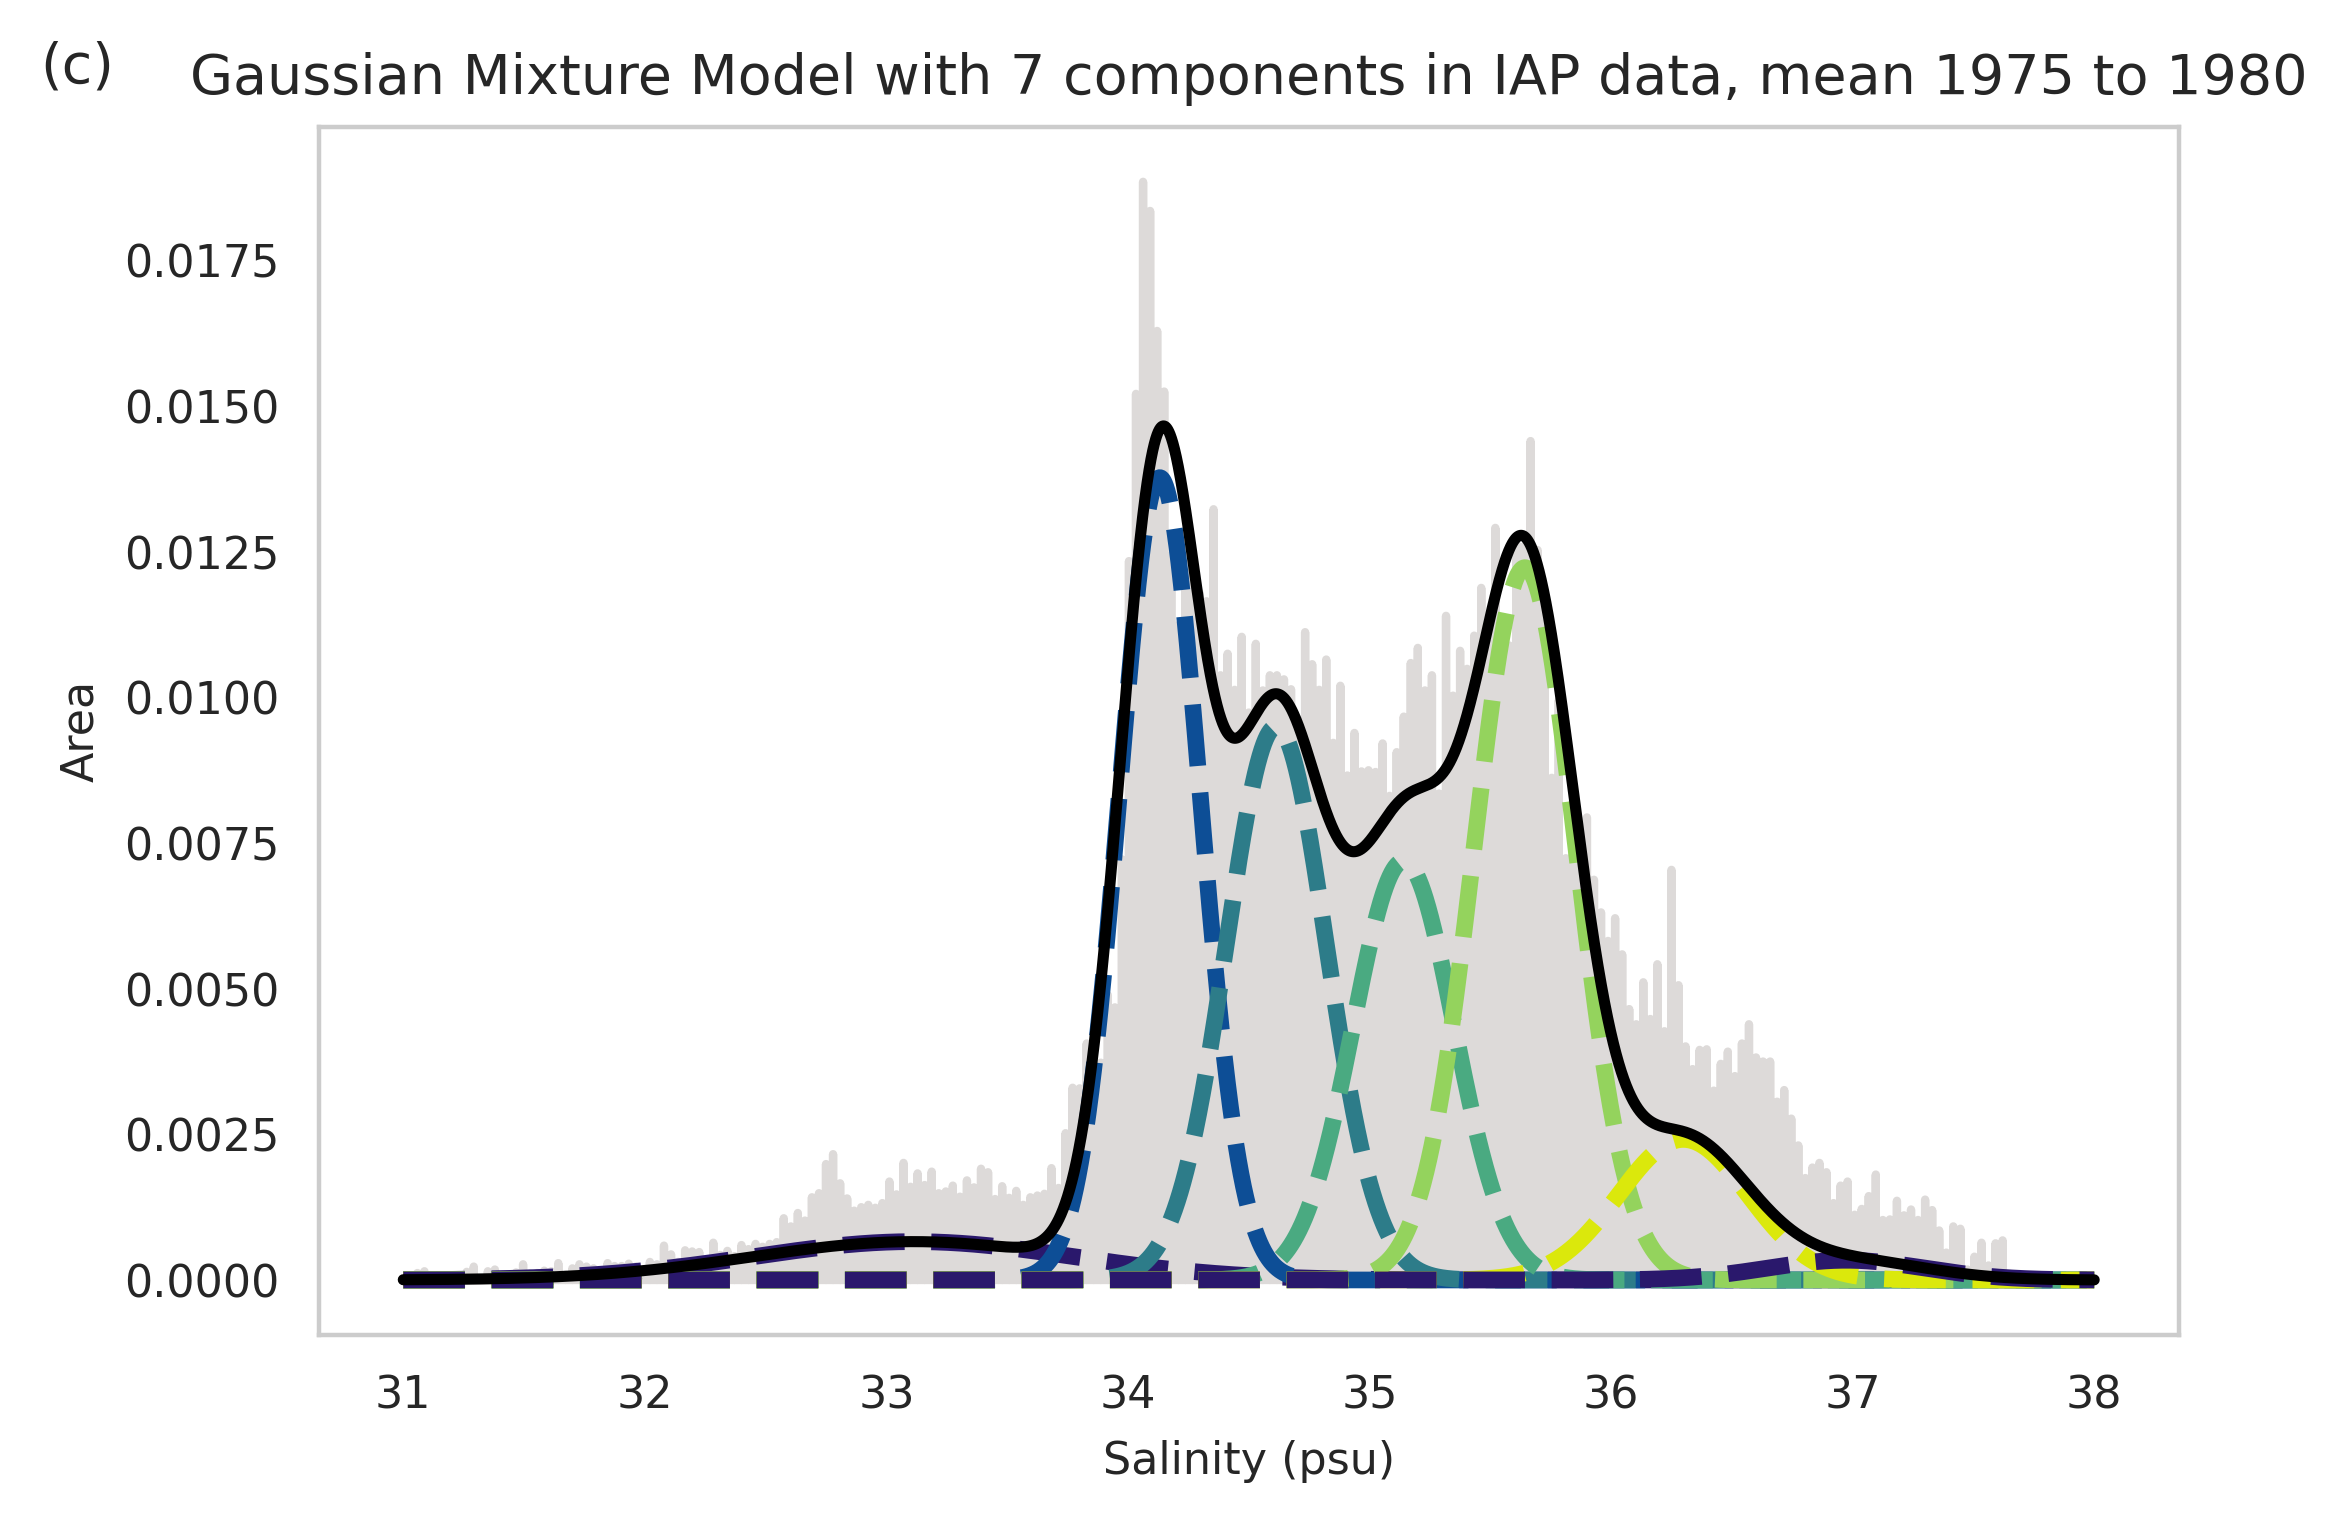

In [17]:
n=7
%load_ext autoreload 
%autoreload 2

import seaborn as sns
sns.set_style(style="whitegrid") #comment out if don't want seaborn background

from clustering_tools import *
mean_con,sigma_con,weights_con,gm=GMM_timedep((regrid_iap[3:8].mean('time')).where(regrid_iap.latitude<65),n,'IAP data, mean 1975 to 1980',matching_paper=1,subplot_label='(c)') 

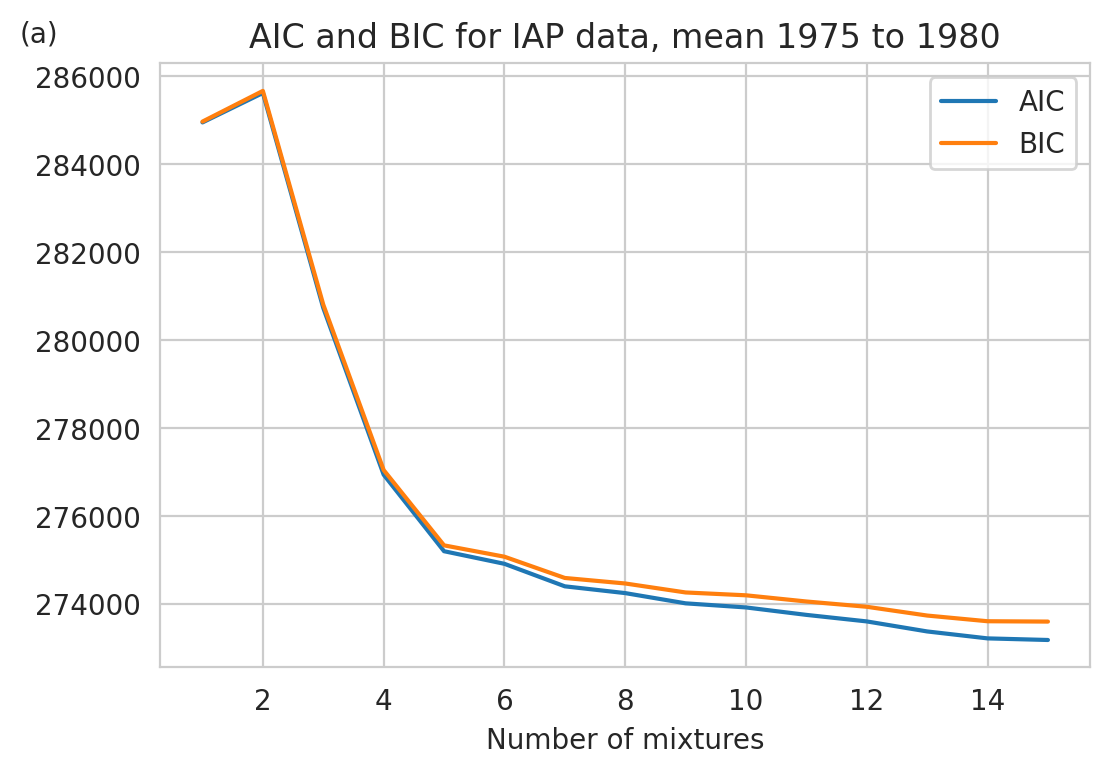

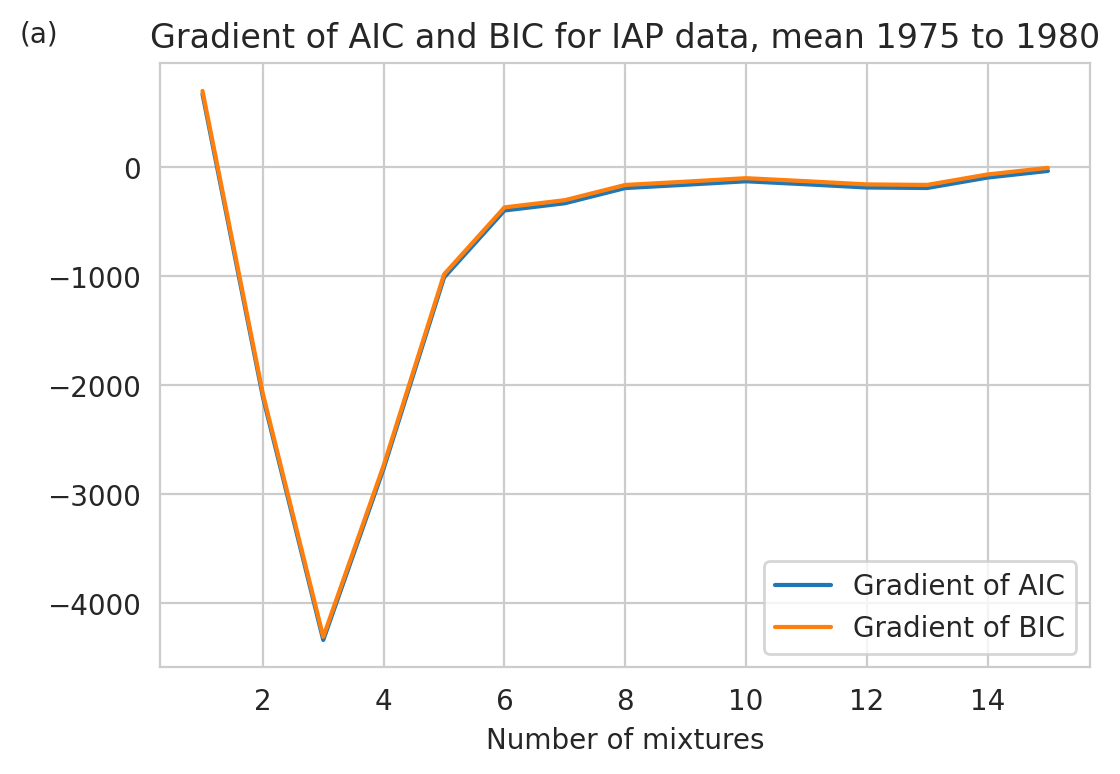

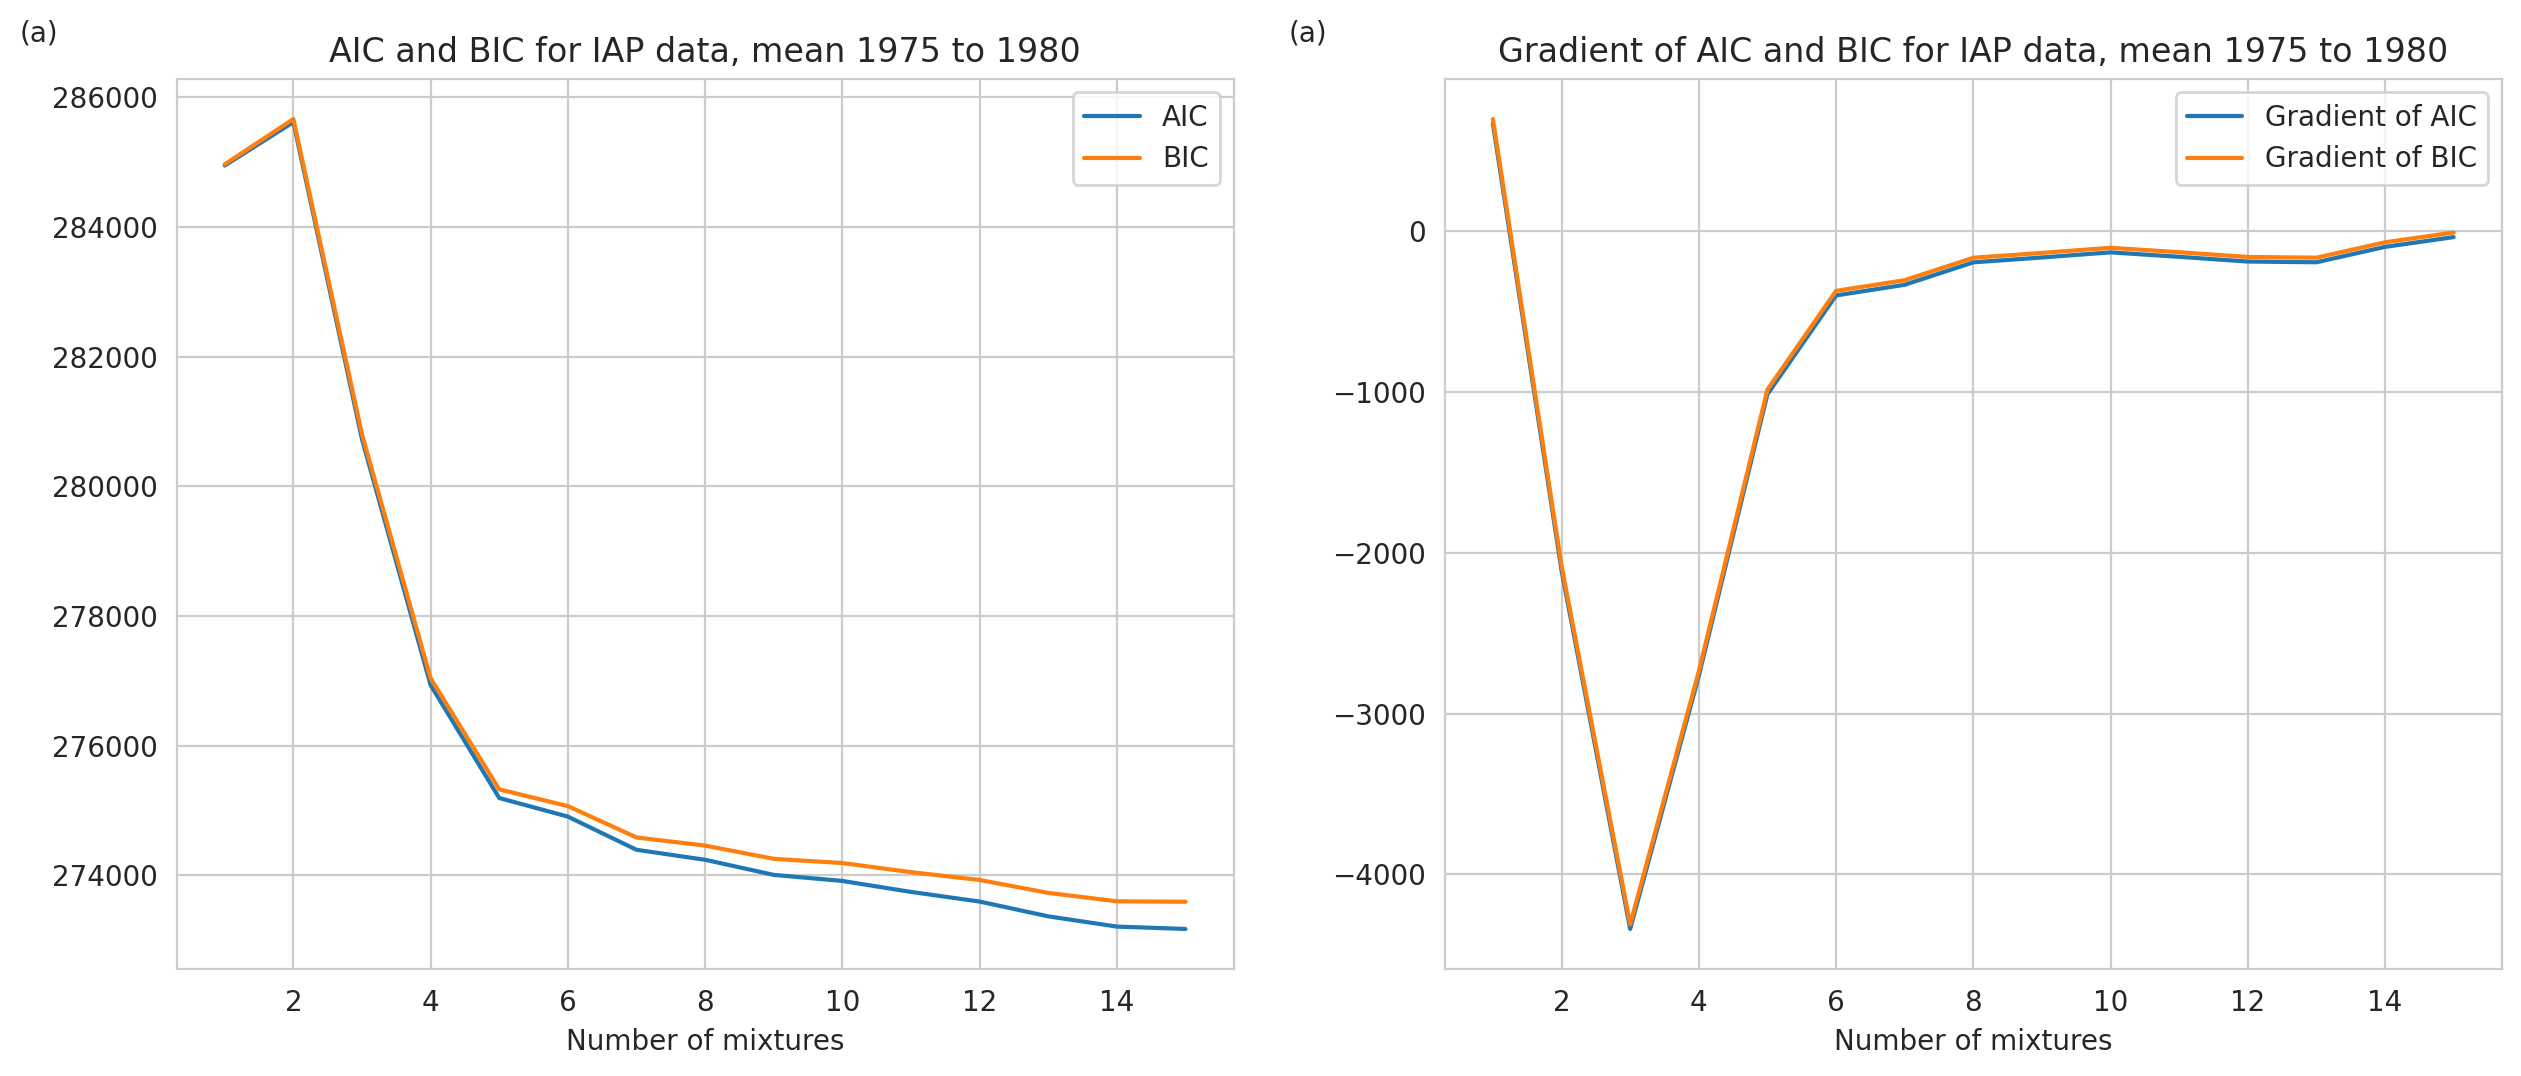

In [8]:
#Look at AIC and BIC metrics
AIC_BIC_timedep(regrid_iap[3:8].mean('time'),'IAP data, mean 1975 to 1980',subplot_label='(a)',subplot_label2='(a)')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


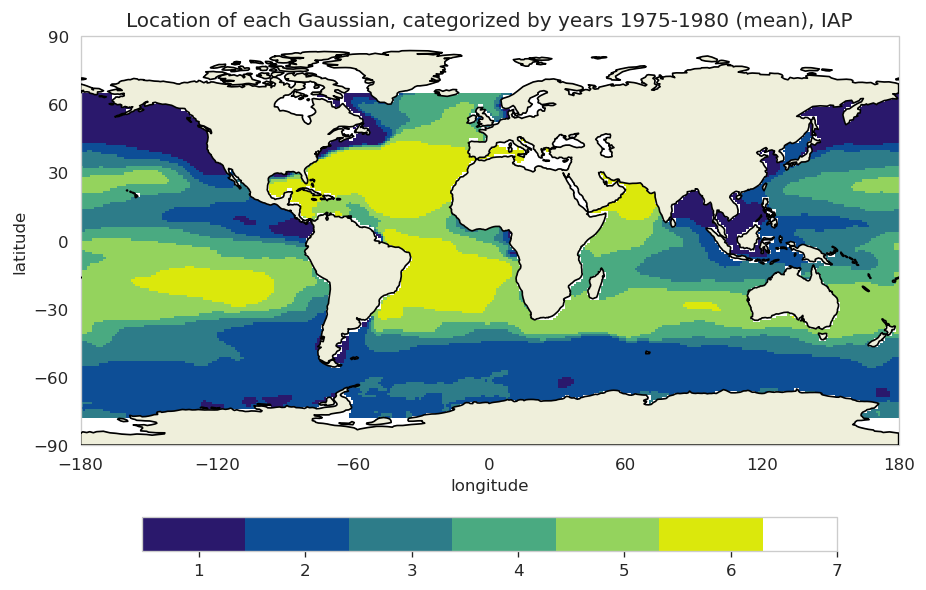

In [18]:
from clustering_tools import clusters
%load_ext autoreload
%autoreload 2
y,a2=clusters(gm,regrid_iap[3:8].mean('time'),'Location of each Gaussian, categorized by years 1975-1980 (mean), IAP',n,matching_paper=1,subplot_label='')

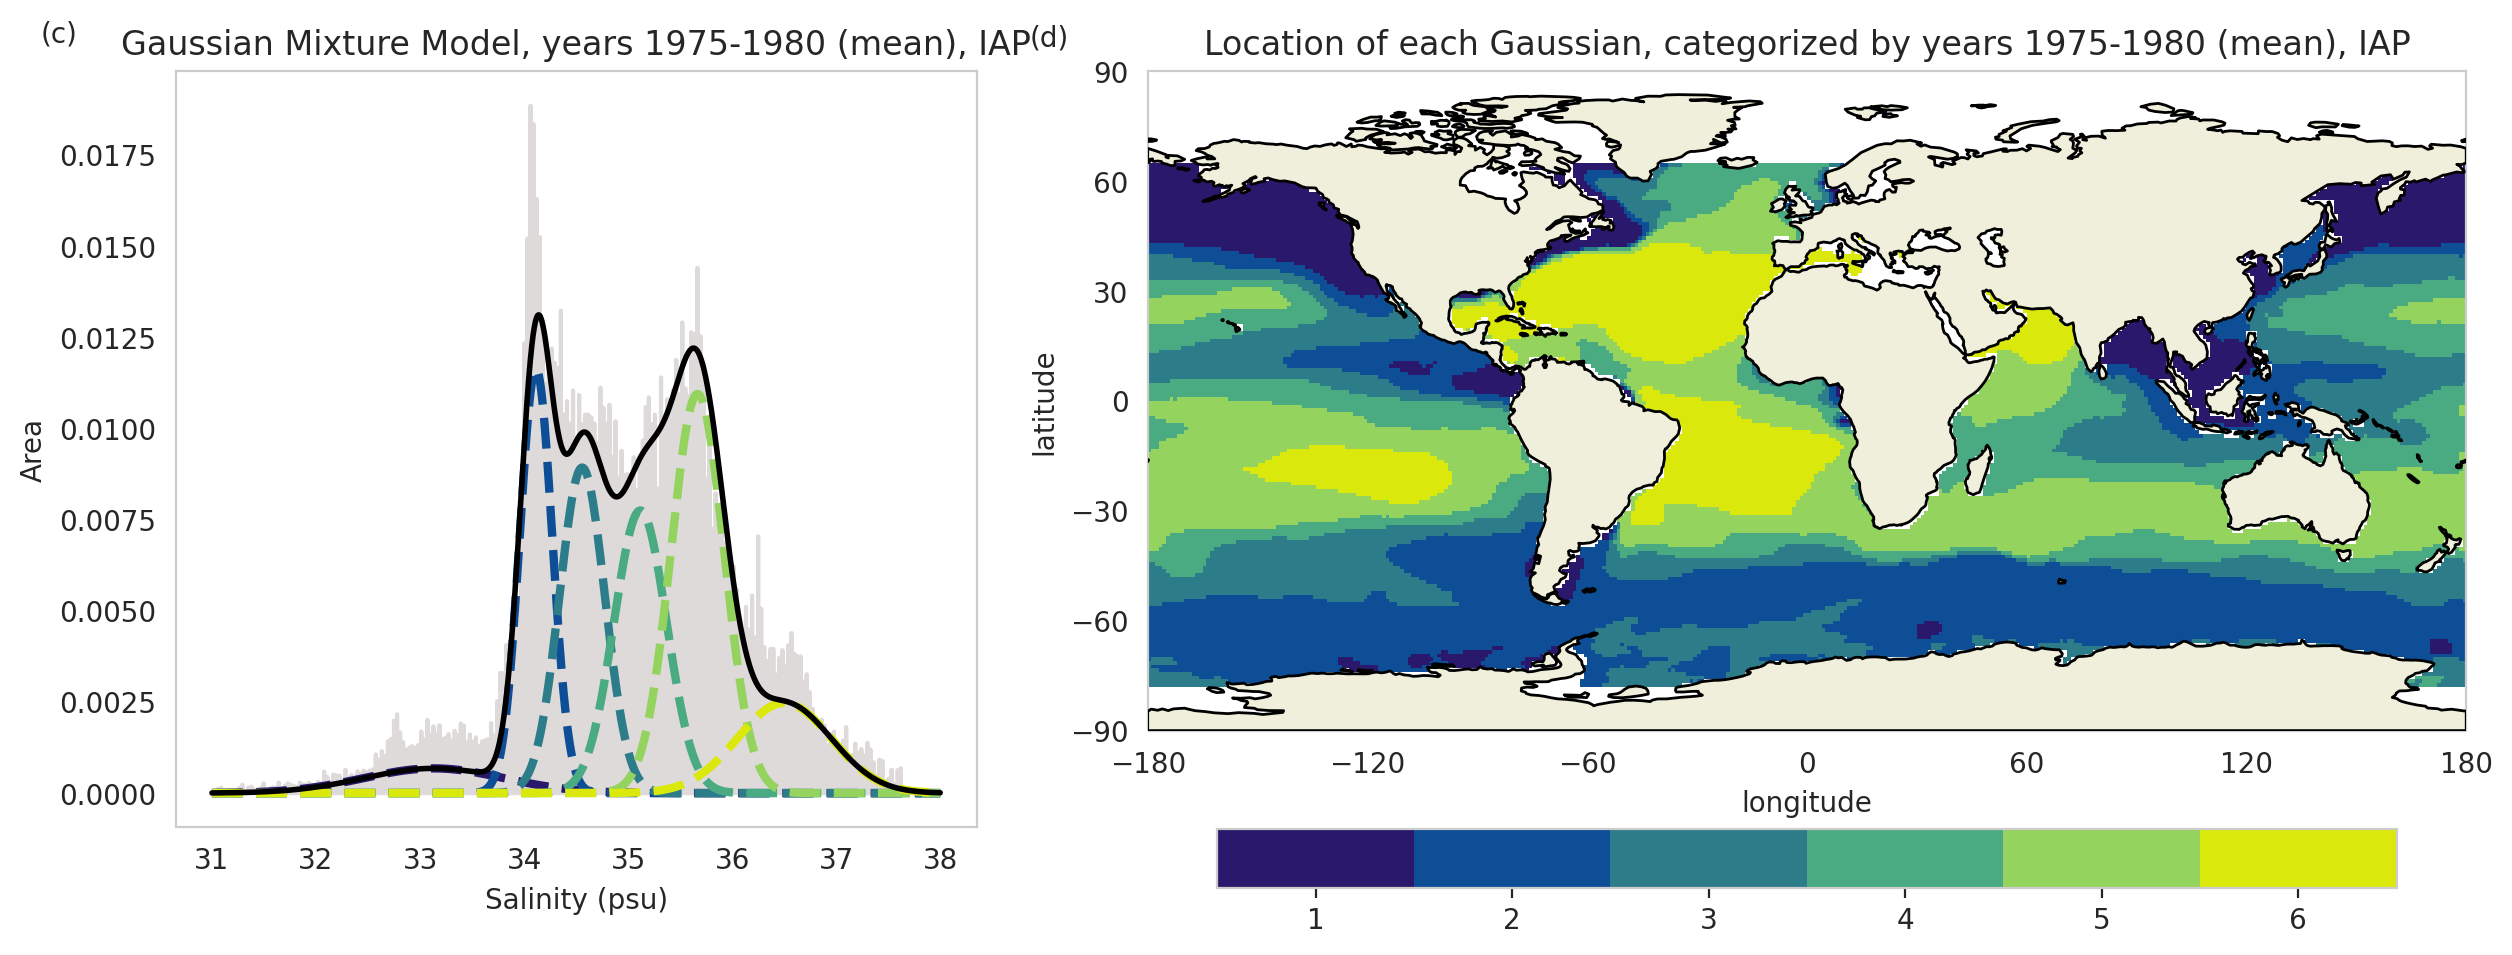

In [19]:
from clustering_tools import GMM_plot_withmap

GMM_plot_withmap((regrid_iap[3:8].mean('time')).where(regrid_iap.latitude<65),n,', years 1975-1980 (mean), IAP','Location of each Gaussian, categorized by years 1975-1980 (mean), IAP',subplot_label='(c)',subplot_label2='(d)') 
#mpl.pyplot.savefig('IAP_GMM_andmap_5year.png', dpi=300,bbox_inches='tight')

## Now take the mean of salinity and temperature at each year in each cluster

In [19]:
s=(regrid_iap[3:8,:,:].mean('time')).where(regrid_iap.latitude<65)

x=np.linspace(31,38,10000)
#we have a 50 year time series, we want to find the mean salt at each region defined by the first year at each of these years
salt_iap=np.empty([50,n])
temp_iap=np.empty([50,n])
for j in range(0,50):
    s_new=(regrid_iap[j]).where(regrid_iap.latitude<65)
    t_new=(regrid_iap_temp[j]).where(regrid_iap.latitude<65)
    for i in range(0,n):
        salt_iap[j,i]=area_weighted_disjoint(area,i,s,s_new,x,a2)
        temp_iap[j,i]=area_weighted_disjoint(area,i,s,t_new,x,a2)
        
change_iap=salt_iap[:,:]-np.mean(salt_iap[3:5,:],0)
change_iap_temp=temp_iap[:,:]-np.mean(temp_iap[3:5,:],0)

change_iap=change_iap[3:48,:] #cut to the first 45 years (1975 to 2019)
change_iap_temp=change_iap_temp[3:48,:] #cut to the first 45 years (1975 to 2019)

Text(0.5, 1.0, 'Change in salinity in each region, IAP')

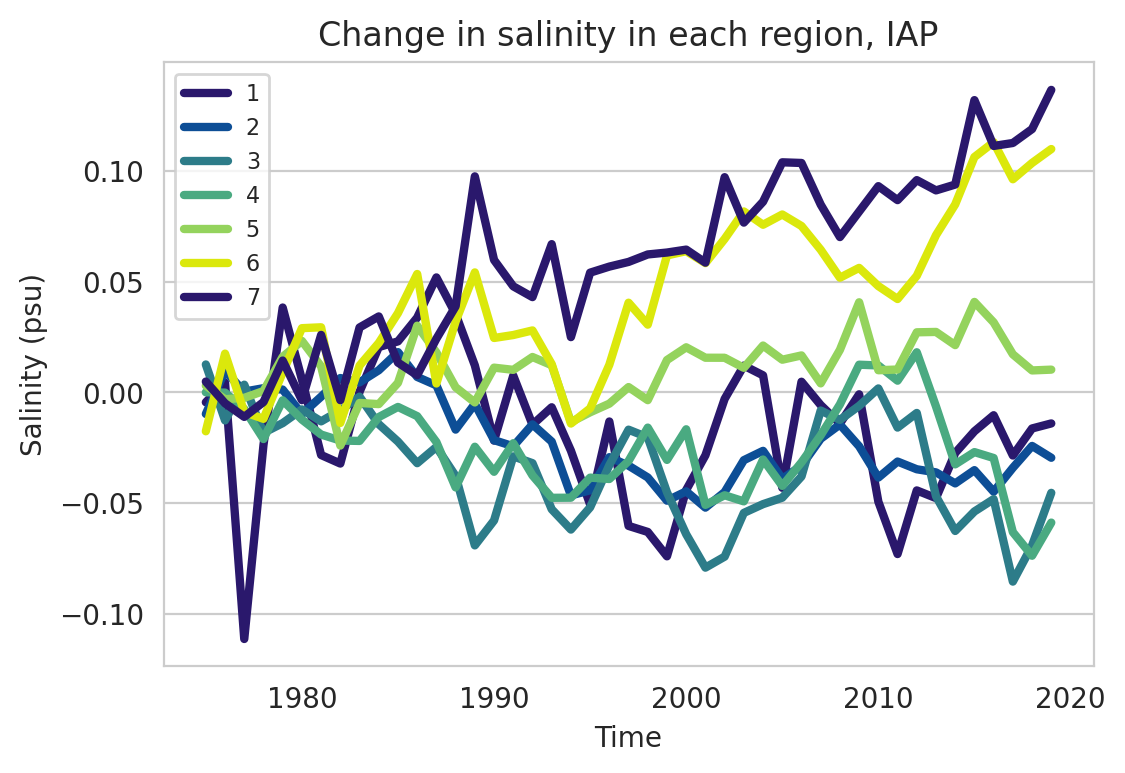

In [21]:
import seaborn as sns
sns.set_style(style="whitegrid") #comment out if don't want seaborn background


fig, ax = plt.subplots()
ax.xaxis.grid()
from cycler import cycler
ax.set_prop_cycle(cycler('color',['#2a186c', '#0d4e96', '#2d7c89', '#4aaa81', '#94d35d', '#DBE80C'])) #comment out if don't want these colours
plt.plot(np.linspace(1975,2019,45),change_iap,linewidth=3)

plt.legend(['1','2','3','4','5','6','7'],loc='upper left',fontsize=8)
plt.xlabel('Time')
plt.ylabel('Salinity (psu)')
plt.title('Change in salinity in each region, IAP')

Text(0.5, 1.0, 'Change in temperature in each region, IAP')

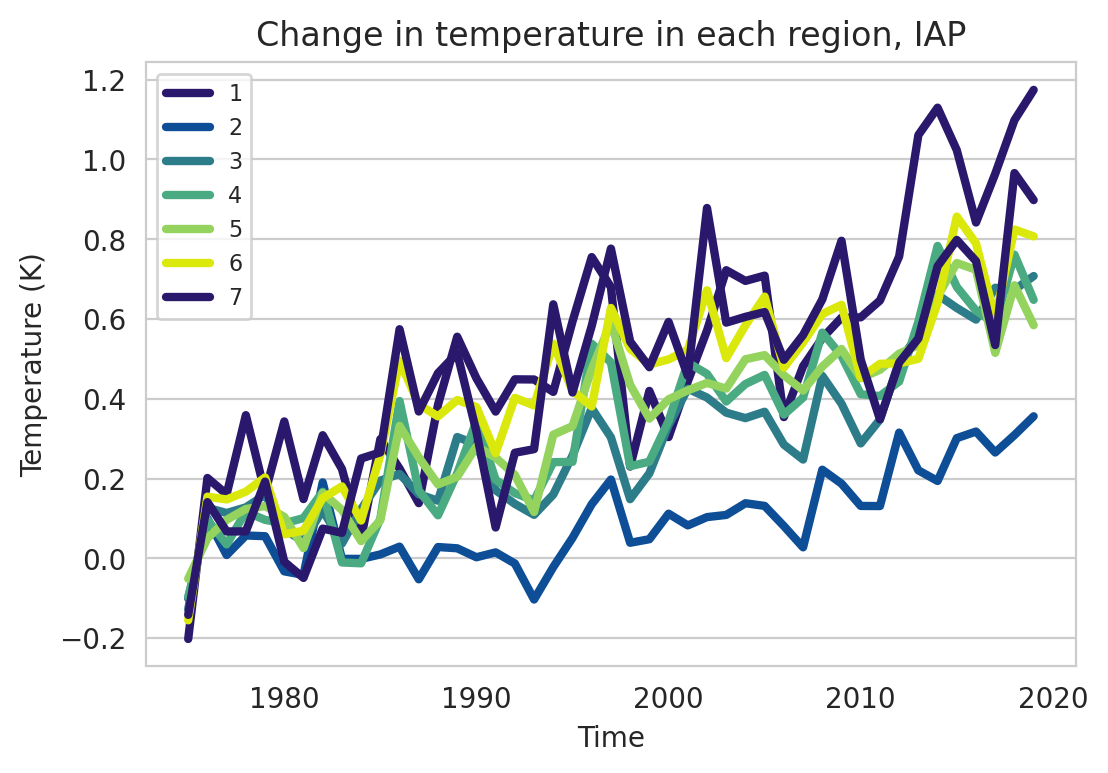

In [22]:
import seaborn as sns
sns.set_style(style="whitegrid") #comment out if don't want seaborn background
fig, ax = plt.subplots()
ax.xaxis.grid()
from cycler import cycler
ax.set_prop_cycle(cycler('color',['#2a186c', '#0d4e96', '#2d7c89', '#4aaa81', '#94d35d', '#DBE80C'])) #comment out if don't want these colours
plt.plot(np.linspace(1975,2019,45),change_iap_temp,linewidth=3)

plt.legend(['1','2','3','4','5','6','7'],loc='upper left',fontsize=8)
plt.xlabel('Time')
plt.ylabel('Temperature (K)')
plt.title('Change in temperature in each region, IAP')

## If we applied linear response theory without doing any block bootstrapping:

In [24]:
#Get the area of each cluster
def area_disjoint(area,i,salt_surface,thing_to_weight,x,a2):
    return ((thing_to_weight*area).where(salt_surface>(x[a2[i]])).where(salt_surface<(x[a2[i+1]]))).sum()

ones_grid=regrid_iap[0,:,:].where(regrid_iap[0,:,:]==1, other=1)
area_cluster=np.empty(n)
for i in range(0,n):
    area_cluster[i]=area_disjoint(area,i,s,ones_grid,x,a2)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


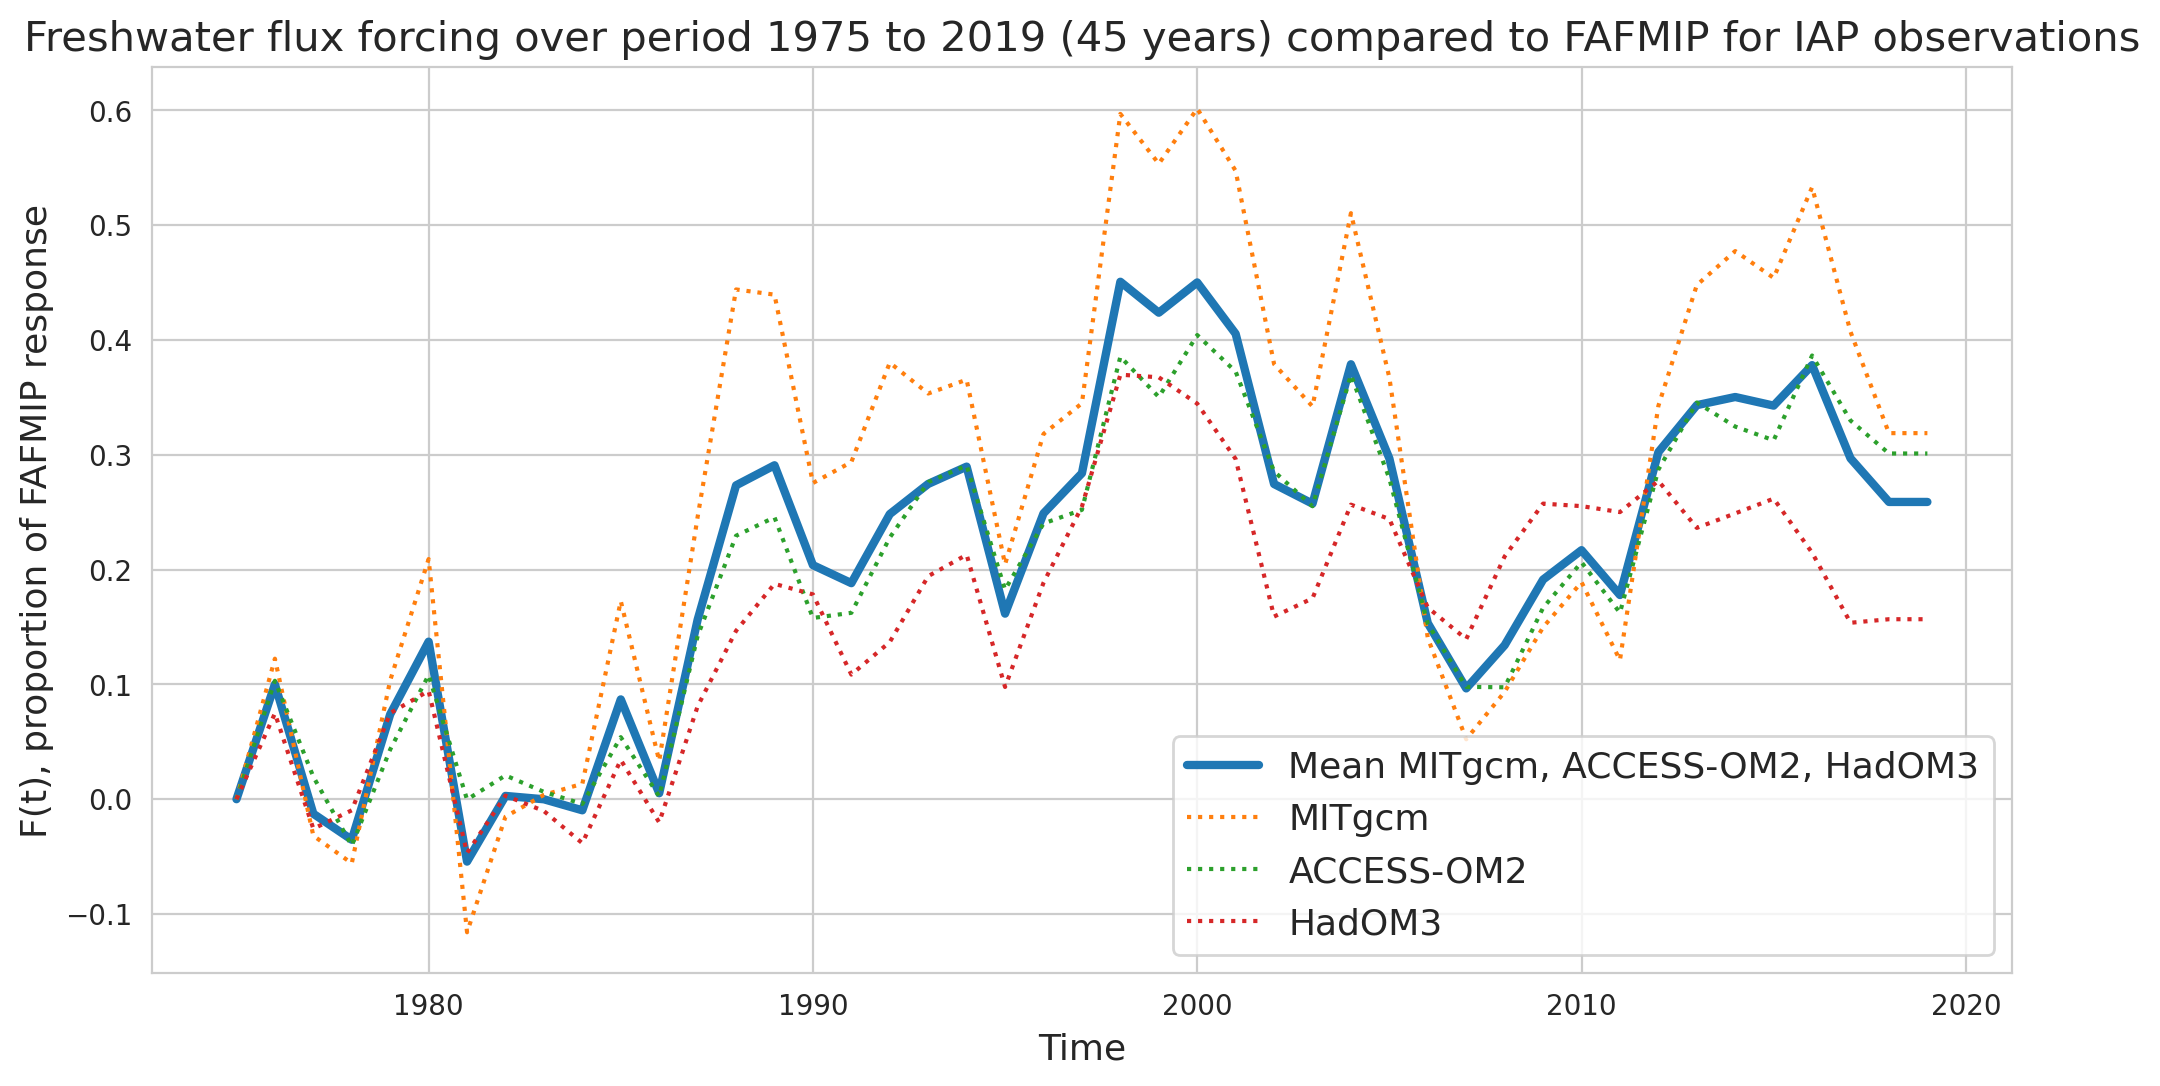

In [27]:
from linear_response_tools import linear_response_single
%load_ext autoreload
%autoreload 2

change_water,change_heat=linear_response_single(change_iap,change_iap_temp,a2,regrid_iap[3:48],n,weighted=1,area_cluster=area_cluster)

In [28]:
print(change_water)
print(change_heat)

0.2819158793826972
0.4456926935878361


## Perform block bootstrapping to generate artificial ensemble.

We also calculate the pvalues associated with block bootstrapping confidence interval so we can check if they meet significance criteria that we found in individual_ensemble_member_CESM.ipynb

In [ ]:
# !!!! Note this takes a while to run. Can instead load in the pickled output below if you want.

np.random.seed(0)
pvalue_bootstrap_store=np.empty([n]) #p value from block bootstrapped confidence interval


#FInd trend in each region and then block bootstrap
trend=np.empty([45,n])
pvalue_salt=np.empty([n])
for i in range(0,n):
    p=scipy.stats.linregress(np.linspace(0,44,45), y=change_iap[:,i], alternative='two-sided')
    trend[:,i]=p.intercept+p.slope*np.linspace(0,44,45)
    pvalue_salt[i]=p.pvalue



#Find the temp trend for each region and then block bootstrap
trend_temp=np.empty([45,n])
pvalue_temp=np.empty([n])
for i in range(0,n):
    p=scipy.stats.linregress(np.linspace(0,44,45), y=change_iap_temp[:,i], alternative='two-sided')
    trend_temp[:,i]=p.intercept+p.slope*np.linspace(0,44,45)
    pvalue_temp[i]=p.pvalue


from recombinator.block_bootstrap import circular_block_bootstrap

# number of replications for bootstraps (number of resampled time-series to generate)
B = 3000

y_star_cb \
    = circular_block_bootstrap(np.concatenate([change_iap-trend,change_iap_temp-trend_temp],axis=1), 
                               block_length=2, 
                               replications=B, replace=True)
bootstrap_salt=y_star_cb[:,:,0:n]
bootstrap_temp=y_star_cb[:,:,n:2*n]
#so we now have 50 "members" from performing block bootstrapping with 1 member that we had. Let's put them now in a list
salt_list_bootstrap=[]
for i in range(0,B):
    salt_list_bootstrap.append(trend+bootstrap_salt[i,:,:])

temp_list_bootstrap=[]
for i in range(0,B):
    temp_list_bootstrap.append(trend_temp+bootstrap_temp[i,:,:])
    

#store the bootstrapped p values    
bootstrapped_slope=np.empty([B,n])
for i in range(0,B):
    for j in range(0,n):
        p=scipy.stats.linregress(np.linspace(0,44,45), y=salt_list_bootstrap[i][:,j], alternative='two-sided')
        bootstrapped_slope[i,j]=p.slope

for j in range(0,n):
    z=bootstrapped_slope[:,j].mean()/bootstrapped_slope[:,j].std()
    pvalue_bootstrap_store[j] = scipy.stats.norm.sf(abs(z)) #we use this form because we expect the null hypothesis to be less than values
    

#Apply linear response theory    
from linear_response_tools import linear_response_list_bootstrap
%load_ext autoreload
%autoreload 2

with warnings.catch_warnings(): #get rid of the contiugous warning, github conversation about it says it is unnecessary: https://github.com/JiaweiZhuang/xESMF/issues/25
    warnings.filterwarnings('ignore')
    ###### IF YOU WANT AREA WEIGHTED:
    water_boot,heat_boot,water_boot_modelspread,heat_boot_modelspread=linear_response_list_bootstrap(salt_list_bootstrap,temp_list_bootstrap,regrid_iap[3:48,:,:],n,a2,1,weighted=1,area_cluster=area_cluster,returns=4)
    ###### IF YOU DO NOT WANT AREA WEIGHTED:
    #water_boot,heat_boot=linear_response_list_bootstrap(salt_list_bootstrap,temp_list_bootstrap,regrid_iap[3:48,:,:],n,a2,1)
import pickle
with open("bootstrap_change_water_3000_iap_5yr", "wb") as fp:   #Pickling
    pickle.dump(water_boot, fp)
with open("bootstrap_change_heat_3000_iap_5yr", "wb") as fp:   #Pickling
    pickle.dump(heat_boot, fp)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [47]:
pvalue_bootstrap_store

array([6.32615300e-02, 7.55338830e-09, 1.89514360e-03, 6.33684263e-02,
       7.75428547e-06, 3.47036402e-27])

In [50]:
print(pvalue_bootstrap_store[0]<0.18)
print(pvalue_bootstrap_store[1]<0.05)
print(pvalue_bootstrap_store[2]<0.18)
print(pvalue_bootstrap_store[4]<0.18)
print(pvalue_bootstrap_store[5]<0.05)

True
True
True
True
True


In [22]:
import os
cwd = os.getcwd() #current working directory
with open(cwd+"/pickled_files/bootstrap_change_water_3000_iap_5yr", "rb") as fp:   #Load in the pickled files from above
    water_boot=pickle.load(fp)
with open(cwd+"/pickled_files/bootstrap_change_heat_3000_iap_5yr", "rb") as fp:   #Load in the pickled files from above
    heat_boot=pickle.load(fp)

In [ ]:
print(water_boot.mean())
print(water_boot.std())

In [44]:
print(heat_boot.mean())
print(heat_boot.std())

0.39934999540006993
0.1277486560922171


## Get as a percent change per degree C

The above result is in terms of the FAFMIP perturbation. However, to compare with previous results (and with the Clausius-Clapeyron rate), we want to write this in terms of a percent amplification per degree C. To do this, we need both the change in surface air temperature over the period of interest and a measure of the climatological hydrological cycle strength. Thus, we have to introduce additional assumptions such as using choosing a data product of fluxes as the true strength of the climatological cycle. Here we choose to use the ECCO freshwater fluxes - this is because the FAFMIP perturbation includes change in river runoff and sea ice melt and so the baseline climatological estimate also needs to include this - which ECCO does. 

We quantify the total strength of the FAFMIP perturbation as the absolute value integrated and the total strength of the climatological pattern as the absolute value integrated. Thus, we do not assume that the climatological pattern necessarily projects onto the FAFMIP pattern

In [32]:
fw_fluxes=[]
for i in range(0,10):
    yr=1992+i
    for j in range(1,13):
        if j<10:
            f='/scratch/abf376/ecco_freshwater_flux_regrid/OCEAN_AND_ICE_SURFACE_FW_FLUX_mon_mean_%d-0%d_ECCO_V4r4_latlon_0p50deg.nc' %(yr,j)
        else: 
            f='/scratch/abf376/ecco_freshwater_flux_regrid/OCEAN_AND_ICE_SURFACE_FW_FLUX_mon_mean_%d-%d_ECCO_V4r4_latlon_0p50deg.nc' %(yr,j)
        s=xr.open_dataset(f)['oceFWflx']
        fw_fluxes.append(s[0,:,:])

mean_fw_flux_92to01=sum(fw_fluxes)/len(fw_fluxes)

### Scale by choosing strength of perturbation and climatological cycle as the absolute value integrated

In [33]:
#Find the wfo strength in Sv

#water flux from fafmip
f='/scratch/abf376/FAFMIP_wfo_v2.nc' 
file2read = netCDF4.Dataset(f,'r')
#print(file2read.variables)
wfo = xr.open_dataset(f)['water_flux_into_sea_water']
wfo=wfo.where(wfo<1E19)

#Define area grid
from area_grid import *
area_wfo=area_grid(latitudes=np.array(wfo.latitude),longitudes=wfo.longitude)
area_wfo=xr.DataArray(area,dims=["latitude","longitude"],coords=[wfo.latitude,wfo.longitude])

rho=1000
#integrate the absolute value
watercycle_fafmip_pert=(np.abs(wfo[:,:,:].where(wfo[0,:,:].latitude<65).mean('time'))*area_wfo).sum()/(area_wfo.where(wfo[0,:,:].latitude<65).sum()) #in kg/m^2.s


#sverdrup is 1E6 m^3/s
watercycle_fafmip_pert_map_inSv=(np.abs(wfo[:,:,:].where(wfo[0,:,:].latitude<65).mean('time'))*area_wfo)/rho/1E6
watercycle_fafmip_pert_inSv=watercycle_fafmip_pert_map_inSv.sum()
print(watercycle_fafmip_pert_inSv)

<xarray.DataArray ()>
array(1.08156723)


In [34]:
#Find ECCO strength in this way

area_ecco=area_grid(latitudes=np.array(mean_fw_flux_92to01.latitude),longitudes=mean_fw_flux_92to01.longitude)

ecco_fw_flux_timesarea=(np.abs(mean_fw_flux_92to01.where(mean_fw_flux_92to01.latitude<65))*area_ecco).sum()


#sverdrup is 1E6 m^3/s
rho=1000 #kg/m^3
ecco_fw_flux_timesarea_Sv=ecco_fw_flux_timesarea/rho/1E6 #mean 1970 to 1980
print(ecco_fw_flux_timesarea_Sv)


<xarray.DataArray 'oceFWflx' ()>
array(8.05542997)


In [35]:
#Need to scale by surface air temperature 

#We can try the NASA GISS dataset https://data.giss.nasa.gov/gistemp/ where the file is https://data.giss.nasa.gov/gistemp/tabledata_v4/GLB.Ts+dSST.txt
#Let's define the temperature change as the mean of 2017 to 2021 (two years on either side of 2019) minus the mean of 1973 to 1977 (two years on either side of 1975)
Delta_SAT_GISS=((92+85+98+102+85)/5-(16-7-1-10+18)/5)/100
print(Delta_SAT_GISS)

0.892


In [36]:
obs=water_boot.mean()
std_bootstrap=water_boot.std()

print("The percent increase in the hydrological cycle is %4.3f pm %4.3f percent" %(100*obs*watercycle_fafmip_pert_inSv/ecco_fw_flux_timesarea_Sv,100*std_bootstrap*watercycle_fafmip_pert_inSv/ecco_fw_flux_timesarea_Sv))
print("The percent increase in the hydrological cycle is %4.3f pm %4.3f percent per degree C" %(100*obs*watercycle_fafmip_pert_inSv/ecco_fw_flux_timesarea_Sv/Delta_SAT_GISS,100*std_bootstrap*watercycle_fafmip_pert_inSv/ecco_fw_flux_timesarea_Sv/Delta_SAT_GISS))

The percent increase in the hydrological cycle is 4.027 pm 1.078 percent
The percent increase in the hydrological cycle is 4.515 pm 1.209 percent per degree C


## Let's calculate the W/m^2 change for the heat flux

In [45]:
#water flux from fafmip
f='/scratch/abf376/FAFMIP_hfds_v2.nc' #this is the first 50 years
file2read = netCDF4.Dataset(f,'r')
#print(file2read.variables)
hfds = xr.open_dataset(f)['surface_downward_heat_flux_in_sea_water']
hfds=hfds.where(hfds<1E19)

In [46]:
hfds_fafmip_pert=((hfds[:,:,:].where(hfds[0,:,:].latitude<65).mean('time'))*area_wfo).sum()/(area_wfo.where(hfds[0,:,:].latitude<65).sum()) #in W/m^2

print(hfds_fafmip_pert)
print(heat_boot.mean()*hfds_fafmip_pert) #this is the block bootstrapped proportion
print(heat_boot.std()*hfds_fafmip_pert)

<xarray.DataArray ()>
array(1.3967295)
Coordinates:
    time     datetime64[ns] 2101-01-16T12:00:00
<xarray.DataArray ()>
array(0.55778392)
Coordinates:
    time     datetime64[ns] 2101-01-16T12:00:00
<xarray.DataArray ()>
array(0.17843032)
Coordinates:
    time     datetime64[ns] 2101-01-16T12:00:00


### Make plot of IAP data and how it is block bootstrapped. This is making Fig 2 in the paper

In [74]:
#First get the linear trends

change_iap=salt_iap[3:48,:]-np.mean(salt_iap[3:5,:],0)

trend=np.empty([45,6])
pvalue_salt=np.empty([6])
for i in range(0,6):
    p=scipy.stats.linregress(np.linspace(0,44,45), y=change_iap[:,i], alternative='two-sided')
    trend[:,i]=p.intercept+p.slope*np.linspace(0,44,45)
    pvalue_salt[i]=p.pvalue
    
trend_temp=np.empty([45,n])
pvalue_temp=np.empty([n])
for i in range(0,n):
    #p=scipy.stats.linregress(np.linspace(0,49,50), y=change_cesm[:,i], alternative='two-sided')
    p=scipy.stats.linregress(np.linspace(0,44,45), y=change_iap_temp[:,i], alternative='two-sided')
    trend_temp[:,i]=p.intercept+p.slope*np.linspace(0,44,45)
    pvalue_temp[i]=p.pvalue

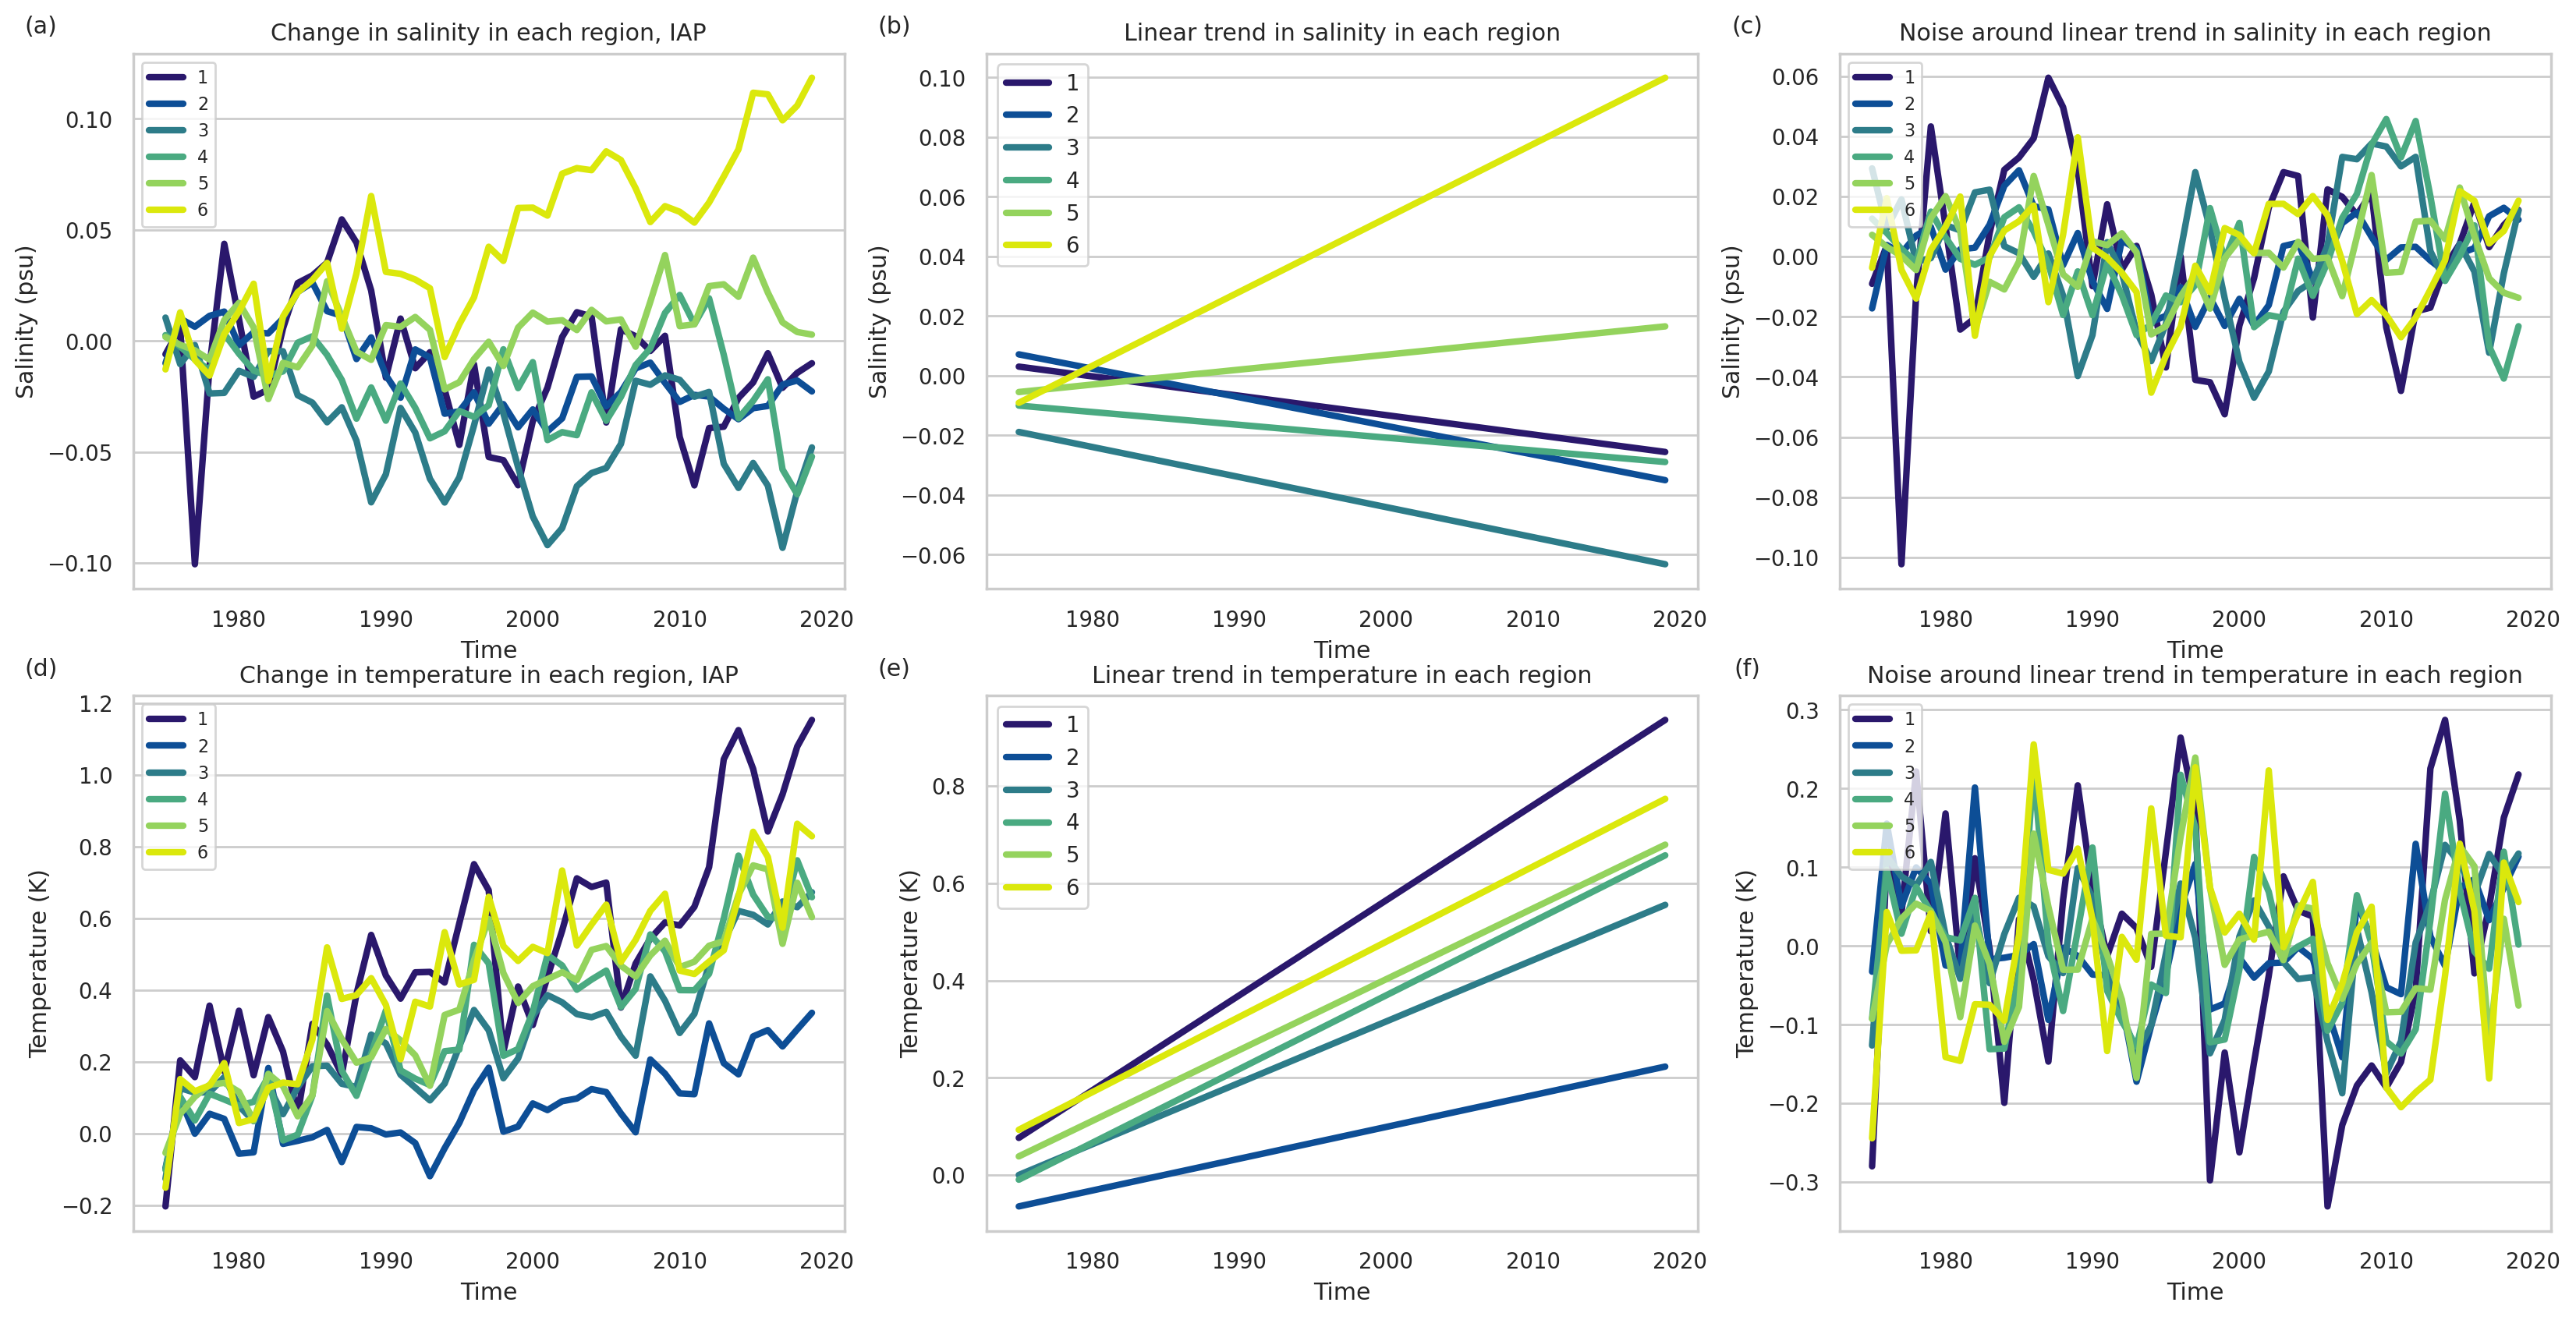

In [75]:
import seaborn as sns
sns.set_style(style="whitegrid") #comment out if don't want seaborn background


fig, ((ax1, ax2,ax3), (ax4, ax5,ax6)) = plt.subplots(2,3,figsize=(20,10))
from cycler import cycler

#PANEL A
ax1.xaxis.grid()
ax1.set_prop_cycle(cycler('color',['#2a186c', '#0d4e96', '#2d7c89', '#4aaa81', '#94d35d', '#DBE80C'])) #comment out if don't want these colours
ax1.plot(np.linspace(1975,2019,45),change_iap,linewidth=3)

ax1.legend(['1','2','3','4','5','6'],loc='upper left',fontsize=8)
ax1.set_xlabel('Time')
ax1.set_ylabel('Salinity (psu)')
ax1.set_title('Change in salinity in each region, IAP')
ax1.text(-0.13, 1.05, '(a)', horizontalalignment='center',

     verticalalignment='center', transform=ax1.transAxes)


#PANEL B
import matplotlib as mpl
ax2.xaxis.grid()
from cycler import cycler
ax2.set_prop_cycle(cycler('color',['#2a186c', '#0d4e96', '#2d7c89', '#4aaa81', '#94d35d', '#DBE80C'])) #comment out if don't want these colours
ax2.plot(np.linspace(1975,2019,45),trend,linewidth=3) #1975 to 2019
ax2.legend(['1','2','3','4','5','6'])
ax2.set_xlabel('Time')
ax2.set_ylabel('Salinity (psu)')
ax2.set_title('Linear trend in salinity in each region')
ax2.text(-0.13, 1.05, '(b)', horizontalalignment='center',

     verticalalignment='center', transform=ax2.transAxes)


#PANEL C
ax3.xaxis.grid()
from cycler import cycler
ax3.set_prop_cycle(cycler('color',['#2a186c', '#0d4e96', '#2d7c89', '#4aaa81', '#94d35d', '#DBE80C'])) #comment out if don't want these colours
ax3.plot(np.linspace(1975,2019,45),change_iap-trend,linewidth=3) #1975 to 2019
ax3.legend(['1','2','3','4','5','6'],loc='upper left',fontsize=8)
ax3.set_xlabel('Time')
ax3.set_ylabel('Salinity (psu)')
ax3.set_title('Noise around linear trend in salinity in each region')
ax3.text(-0.13, 1.05, '(c)', horizontalalignment='center',

     verticalalignment='center', transform=ax3.transAxes)


#PANEL D
ax4.xaxis.grid()
ax4.set_prop_cycle(cycler('color',['#2a186c', '#0d4e96', '#2d7c89', '#4aaa81', '#94d35d', '#DBE80C'])) #comment out if don't want these colours
ax4.plot(np.linspace(1975,2019,45),change_iap_temp,linewidth=3)

ax4.legend(['1','2','3','4','5','6'],loc='upper left',fontsize=8)
ax4.set_xlabel('Time')
ax4.set_ylabel('Temperature (K)')
ax4.set_title('Change in temperature in each region, IAP')
ax4.text(-0.13, 1.05, '(d)', horizontalalignment='center',

     verticalalignment='center', transform=ax4.transAxes)

#PANEL E
ax5.xaxis.grid()
ax5.set_prop_cycle(cycler('color',['#2a186c', '#0d4e96', '#2d7c89', '#4aaa81', '#94d35d', '#DBE80C'])) #comment out if don't want these colours
ax5.plot(np.linspace(1975,2019,45),trend_temp,linewidth=3) #1975 to 2019
ax5.legend(['1','2','3','4','5','6'])
ax5.set_xlabel('Time')
ax5.set_ylabel('Temperature (K)')
ax5.set_title('Linear trend in temperature in each region')
ax5.text(-0.13, 1.05, '(e)', horizontalalignment='center',

     verticalalignment='center', transform=ax5.transAxes)


#PANEL F
ax6.xaxis.grid()
from cycler import cycler
ax6.set_prop_cycle(cycler('color',['#2a186c', '#0d4e96', '#2d7c89', '#4aaa81', '#94d35d', '#DBE80C'])) #comment out if don't want these colours
ax6.plot(np.linspace(1975,2019,45),change_iap_temp-trend_temp,linewidth=3) #1975 to 2019
ax6.legend(['1','2','3','4','5','6'],loc='upper left',fontsize=8)
ax6.set_xlabel('Time')
ax6.set_ylabel('Temperature (K)')
ax6.set_title('Noise around linear trend in temperature in each region')
ax6.text(-0.13, 1.05, '(f)', horizontalalignment='center',

     verticalalignment='center', transform=ax6.transAxes)


mpl.pyplot.savefig('panels_noise_trend.png', dpi=1000,bbox_inches='tight',facecolor='white',transparent=False)

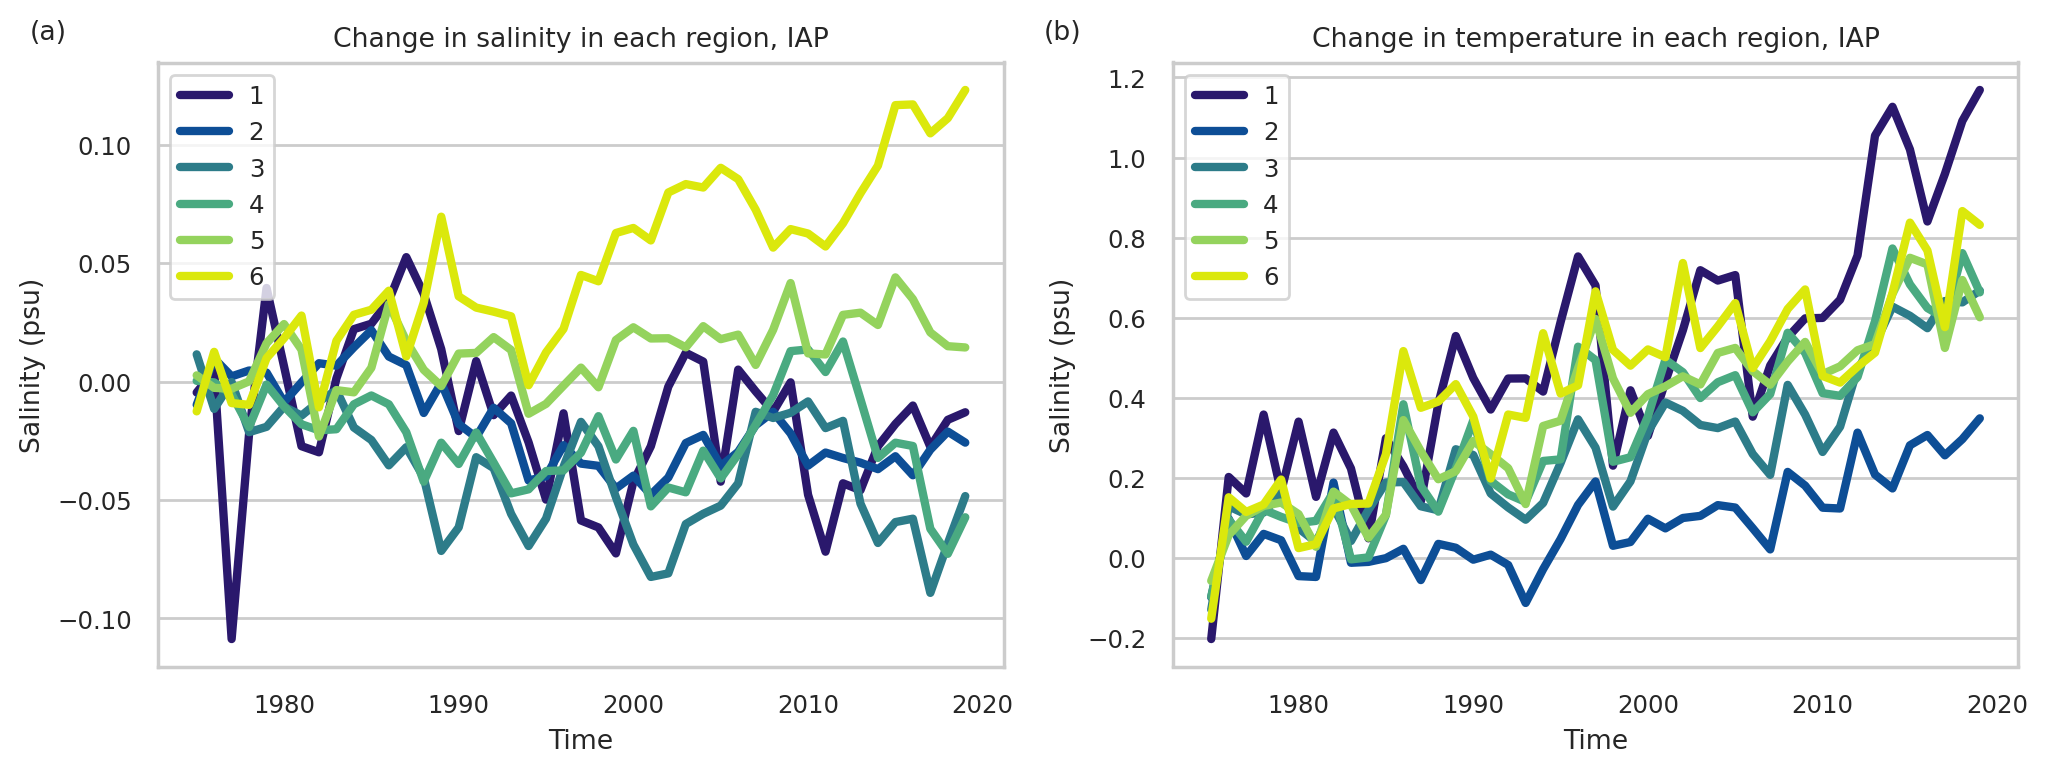

In [24]:
import seaborn as sns
sns.set(font_scale=0.8)
sns.set_style(style="whitegrid") #comment out if don't want seaborn background

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,4))

ax1.xaxis.grid()
from cycler import cycler
ax1.set_prop_cycle(cycler('color',['#2a186c', '#0d4e96', '#2d7c89', '#4aaa81', '#94d35d', '#DBE80C'])) #comment out if don't want these colours
ax1.plot(np.linspace(1975,2019,45),change_iap,linewidth=3)
#plt.legend(['1','2','3','4','5','6'])
ax1.legend(['1','2','3','4','5','6','7'],loc='upper left')
ax1.set_xlabel('Time')
ax1.set_ylabel('Salinity (psu)')
ax1.set_title('Change in salinity in each region, IAP')
ax1.text(-0.13, 1.05, '(a)', horizontalalignment='center', verticalalignment='center', transform=ax1.transAxes)



ax2.xaxis.grid()
from cycler import cycler
ax2.set_prop_cycle(cycler('color',['#2a186c', '#0d4e96', '#2d7c89', '#4aaa81', '#94d35d', '#DBE80C'])) #comment out if don't want these colours
ax2.plot(np.linspace(1975,2019,45),change_iap_temp,linewidth=3)
#plt.legend(['1','2','3','4','5','6'])
ax2.legend(['1','2','3','4','5','6','7'],loc='upper left')
ax2.set_xlabel('Time')
ax2.set_ylabel('Salinity (psu)')
ax2.set_title('Change in temperature in each region, IAP')
ax2.text(-0.13, 1.05, '(b)', horizontalalignment='center', verticalalignment='center', transform=ax2.transAxes)

import matplotlib as mpl
mpl.pyplot.savefig('IAP_data_dual_5yr.png', dpi=300,bbox_inches='tight')

# Test dependencies on number of artificial ensemble members and size of block for block bootstrapping. This is making fig 11 and 12 from the paper

In [39]:
import os
cwd = os.getcwd() #current working directory
with open(cwd+"/pickled_files/bootstrap_change_water_3000_iap_5yr", "rb") as fp:   #Load in the pickled files from above
    bootstrap_change_water_3000=pickle.load(fp)

#iterate through 30 different numbers of members (from 100 up to 3000) and check the mean and standard deviation of that number of artificial ensemble members
mean_by_members=np.empty(30) 
std_by_members=np.empty(30)
for j in range(0,30):
    mean_by_members[j]=bootstrap_change_water_3000[0:(j+1)*100].mean()
    std_by_members[j]=bootstrap_change_water_3000[0:(j+1)*100].std()

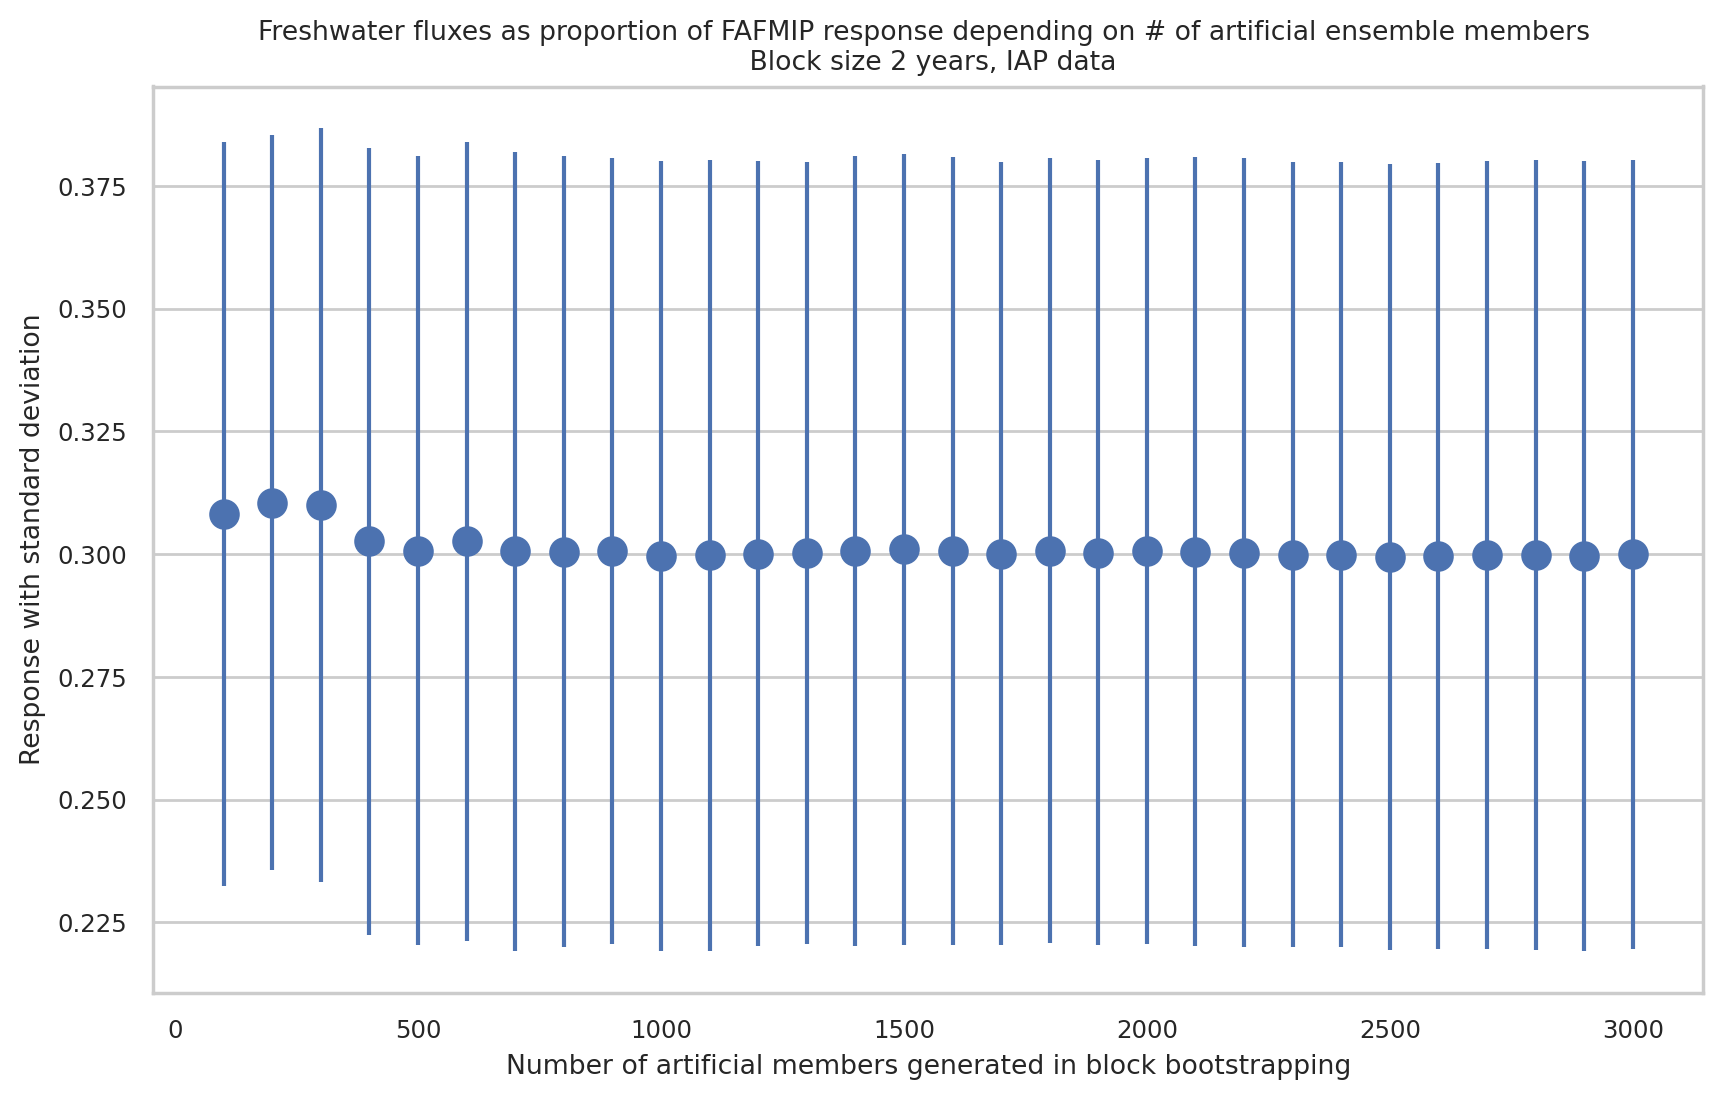

In [40]:
import seaborn as sns
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 200
sns.set_style(style="whitegrid") #comment out if don't want seaborn background
fig,ax=plt.subplots(figsize=(10,6))
plt.errorbar(np.linspace(100,3000,30),mean_by_members,yerr=std_by_members,fmt ='o',
        ms=10)
ax.xaxis.grid()
plt.xlabel('Number of artificial members generated in block bootstrapping')
plt.ylabel('Response with standard deviation')
plt.title('Freshwater fluxes as proportion of FAFMIP response depending on # of artificial ensemble members \n Block size 2 years, IAP data')
mpl.pyplot.savefig('dependency_blocksize_IAP_5yr.png', dpi=1000,bbox_inches='tight',facecolor='white',transparent=False)

In [42]:
#!!! This takes a long time to run, again you can load in the pickled files below instead
#This iterates through block sizes 2 through 8. For each block size, an artificial ensemble is generated around the linear trend and then linear response theory is applied as above

mean_block_size=np.empty(7) #store the means of applying linear response theory with varying block size
std_block_size=np.empty(7) #store the standard deviations of applying linear response theory with varying block size


np.random.seed(0)
#Find trend in each region and then block bootstrap
trend=np.empty([45,n])
pvalue_salt=np.empty([n])
for i in range(0,n):
    p=scipy.stats.linregress(np.linspace(0,44,45), y=change_iap[:,i], alternative='two-sided')
    trend[:,i]=p.intercept+p.slope*np.linspace(0,44,45)
    pvalue_salt[i]=p.pvalue



#Find the temp trend for each region and then block bootstrap
trend_temp=np.empty([45,n])
pvalue_temp=np.empty([n])
for i in range(0,n):
    p=scipy.stats.linregress(np.linspace(0,44,45), y=change_iap_temp[:,i], alternative='two-sided')
    trend_temp[:,i]=p.intercept+p.slope*np.linspace(0,44,45)
    pvalue_temp[i]=p.pvalue

for j in range(2,9):
    from recombinator.block_bootstrap import circular_block_bootstrap

    # number of replications for bootstraps (number of resampled time-series to generate)
    B = 500

    y_star_cb \
        = circular_block_bootstrap(np.concatenate([change_iap-trend,change_iap_temp-trend_temp],axis=1), 
                                   block_length=j, 
                                   replications=B, replace=True)
    bootstrap_salt=y_star_cb[:,:,0:6]
    bootstrap_temp=y_star_cb[:,:,6:12]

    salt_list_bootstrap=[]
    for i in range(0,B):
        salt_list_bootstrap.append(trend+bootstrap_salt[i,:,:])

    temp_list_bootstrap=[]
    for i in range(0,B):
        temp_list_bootstrap.append(trend_temp+bootstrap_temp[i,:,:])
                                   
    n=6
    from linear_response_tools import linear_response_list_bootstrap
    %load_ext autoreload
    %autoreload 2
    with warnings.catch_warnings(): #get rid of the contiugous warning, github conversation about it says it is unnecessary: https://github.com/JiaweiZhuang/xESMF/issues/25
        warnings.filterwarnings('ignore')
        water_boot,heat_boot=linear_response_list_bootstrap(salt_list_bootstrap,temp_list_bootstrap,regrid_iap[3:48,:,:],n,a2,1,weighted=1,area_cluster=area_cluster,returns=2)
                            
    mean_block_size[j-2]=water_boot.mean()
    std_block_size[j-2]=water_boot.std()
    print(j)
 
dep_block_size=np.array([mean_block_size,std_block_size])
import pickle
with open("iap_depblocksize_2to8_500members_5yr", "wb") as fp:   #Pickling so we don't have to rerun
    pickle.dump(dep_block_size, fp)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
2
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
3
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
4
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
5
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
6
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
7
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
8


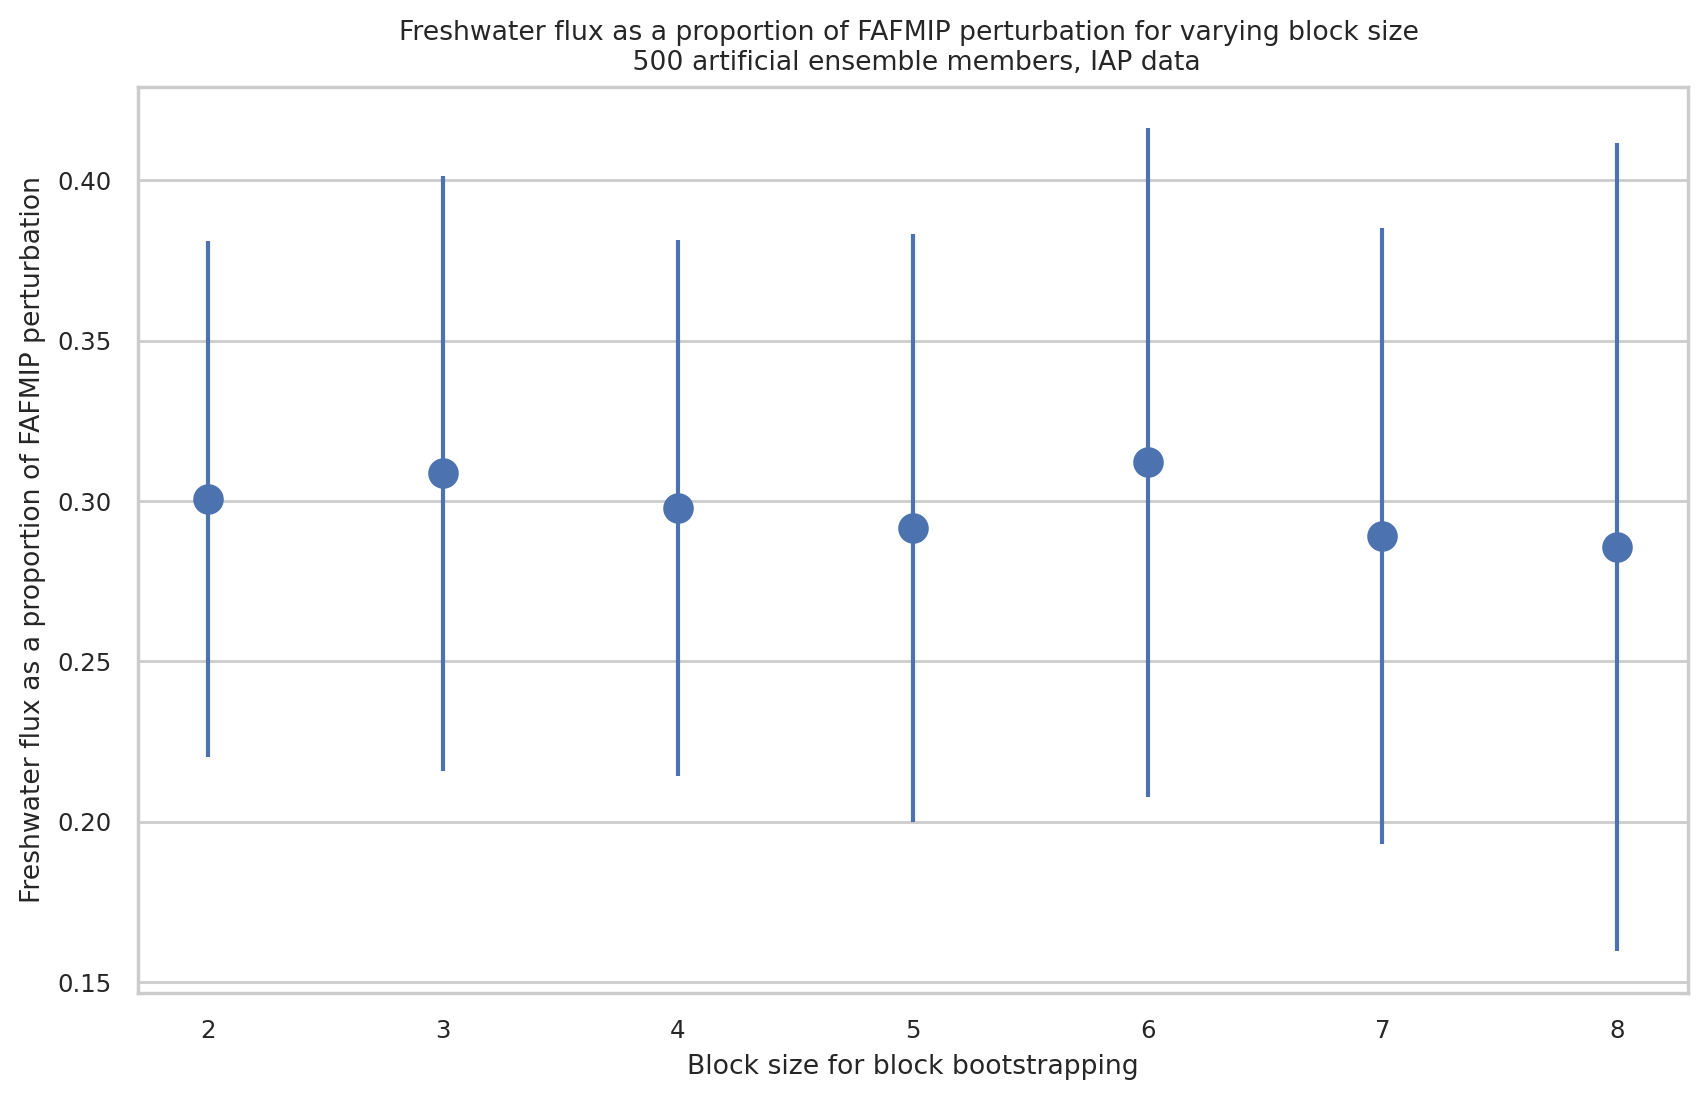

In [43]:
#To skip running the above block, we can just unpickle what we pickled above
import pickle
import os
cwd = os.getcwd() #current working directory

with open(cwd+"/pickled_files/iap_depblocksize_2to8_500members_5yr", "rb") as fp:   #Pickling so we don't have to rerun
    dep_block_size=pickle.load(fp)
fig,ax=plt.subplots(figsize=(10,6))
plt.errorbar(np.linspace(2,8,7), dep_block_size[0,:], yerr=dep_block_size[1,:],fmt ='o',
        ms=10)
plt.xticks(np.arange(2, 9, 1))
ax.set_xlabel('Block size for block bootstrapping')
ax.xaxis.grid()
ax.set_ylabel('Freshwater flux as a proportion of FAFMIP perturbation')
ax.set_title('Freshwater flux as a proportion of FAFMIP perturbation for varying block size \n 500 artificial ensemble members, IAP data')
mpl.pyplot.savefig('dependency_num_members_IAP_5yr.png', dpi=1000,bbox_inches='tight',facecolor='white',transparent=False)